In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset
import classification_models
from classification_models import GetLoader
import time
from datetime import datetime

In [2]:
#导入数据
factor_df=pd.read_csv("/data01/data_for_intern/factor_data_13_19.csv")
return_df=pd.read_csv("/data01/data_for_intern/return_data_13_19.csv")
return_label=return_df.drop(columns=['return_adj_d001','return_adj_d005','car_hs300_b30_d005'])
return_label['car_hs300_b30_d001']=(return_label['car_hs300_b30_d001']>=0)*1
#利用内连接方式合并数据
merged_factor_return = factor_df.merge(return_label,on=["stock_code","trade_date"],how="inner")

In [3]:
#筛选日期节点,以15个交易日为界
date=[]
import datetime
date.append("2013-01-07")
i=0
while(i>-1):
    now=datetime.datetime.strptime(date[i], "%Y-%m-%d")
    if date[i]=="2019-12-02":
        break
    delta=datetime.timedelta(days=28)
    n_days=now+delta
    date.append(n_days.strftime('%Y-%m-%d'))
    i=i+1

In [4]:
date_dict={}
for i in range(len(date)-1):
    #print(i)
    temp_list=[]
    temp_list.append(date[i])
    now=datetime.datetime.strptime(date[i], "%Y-%m-%d")
    while(1):
        delta=datetime.timedelta(days=1)
        #print('k')
        now=now+delta
        #print('l')
        if now.strftime('%Y-%m-%d') == date[i+1]:
            break
        #print('o')
        temp_list.append(now.strftime('%Y-%m-%d'))
        #print(now.strftime('%Y-%m-%d'))
    date_dict[str(i)] = temp_list

In [5]:
valid_date_dict={}
for i in range(1,len(date)):
    #print(i)
    temp_list=[]
    temp_list.append(date[i])
    now=datetime.datetime.strptime(date[i], "%Y-%m-%d")
    k = 0
    while(1):
        delta=datetime.timedelta(days=1)
        #print('k')
        now=now+delta
        #print('l')
        if k>=14:
            break
        #print('o')
        temp_list.append(now.strftime('%Y-%m-%d'))
        #print(now.strftime('%Y-%m-%d'))
        k=k+1
    valid_date_dict[str(i-1)] = temp_list

In [6]:
df_train_dict={}
for i in range(len(date_dict)):
    df_train_dict[str(i)] = merged_factor_return[merged_factor_return['trade_date'].isin (date_dict[str(i)])]

In [7]:
df_valid_dict={}
for i in range(len(valid_date_dict)):
    df_valid_dict[str(i)] = merged_factor_return[merged_factor_return['trade_date'].isin (valid_date_dict[str(i)])]

In [8]:
from datetime import datetime
import roll_data
from rolling_window import *

In [9]:
def unroll_data(join_df, gap_day, roll_day, debug=False):
    # 把前后时间差距大的地方切开
    start = time.time()
    
    all_dfs = []
    
    for code, grp in join_df.groupby('stock_code'):
        grp = grp.sort_index()
        split_point = [0]
        for i in range(len(grp.index) - 1):
            if type(grp.index[i][0]) == str:
                current_day = datetime.strptime(grp.index[i+1][0], '%Y-%m-%d')
                pre_day = datetime.strptime(grp.index[i][0], '%Y-%m-%d')
                gap = (current_day - pre_day).days
            else:
                gap = grp.index[i+1][0] - grp.index[i][0]
            if gap > gap_day:
                if debug:
                    print(grp.index[i+1][0])
                    print(grp.index[i][0])
                    print(gap)
                split_point.append(i+1)
        split_point.append(len(grp.index))
    
        for i in range(len(split_point) - 1):
            if split_point[i+1] - split_point[i] > roll_day:
                all_dfs.append(grp.iloc[split_point[i]:split_point[i+1]])
    time_spend = time.time() - start
    print('Filter large gap...\nTime: %.3f'%(time_spend))
    
        # 把数据展开成sequence
    data_list = []
    label_list = []
    index_list = []

    start = time.time()

    for df in all_dfs:
        grp_data = df.sort_index()
        data_fetch = []
        label_fetch = []
        index = []

        for i in range(grp_data.shape[0] - roll_day):
            data_fetch.append(list(range(i, i + roll_day)))
            label_fetch.append(i + roll_day)
            index.append(grp_data.index[i + roll_day])        

        data_fetch = np.array(data_fetch)
        label_fetch = np.array(label_fetch)

        data = np.take(grp_data.values[:, :-1], data_fetch, axis=0)
        #print(data.shape)
        data = np.transpose(data,(0,2,1))
        label = np.take(grp_data.values[:,-1], label_fetch, axis=0)

        index_list = index_list + index
        data_list.append(data)
        label_list.append(label)
    #print(data_list)
    if len(data_list) != 0:
        data_list = np.concatenate(data_list, axis=0)
        label_list = np.concatenate(label_list, axis=0)

    print('Unrolling Data...\nTime: %.3f s'%(time.time() - start))
    
    return index_list, data_list, label_list

In [10]:
from classification_models import BasicBlock
from classification_models import ResNet1D_LSTM

In [11]:
def ResNet1D_LSTM_rolling_window(df_train_dict, df_valid_dict):
    softmax = nn.Softmax(-1)
    result = {}
    for i in range(1, len(df_train_dict)):
        print("current i is",i)
        temp_df = df_train_dict[str(i)].set_index(['trade_date', 'stock_code'])
        train_index_list, train_data_list, train_label_list = unroll_data(temp_df, 100, 8, debug=False)

        temp_df = df_valid_dict[str(i)].set_index(['trade_date', 'stock_code'])        
        valid_index_list, valid_data_list, valid_label_list = unroll_data(temp_df, 100, 8, debug=False)    
        if len(valid_data_list) == 0:
            continue
        train_index_list, train_data_list, train_label_list = nan_dele(train_index_list, train_data_list, train_label_list)
        valid_index_list, valid_data_list, valid_label_list = nan_dele(valid_index_list, valid_data_list, valid_label_list)
        print(train_data_list.shape, valid_data_list.shape)

        sequence_length = 10  # 序列长度，将图像的每一列作为一个序列
        feature_channel=42
        hidden_size = 256  # 隐藏层的size
        num_layers =  3 # 有多少层
        num_classes = 2
        batch_size = 256
        num_epochs = 200
        learning_rate = 0.001
        device = torch.device("cuda:1")
        
        train_loader, valid_loader = load_data(
            train_index_list, train_data_list, train_label_list,valid_index_list, valid_data_list, valid_label_list, batch_size)
        
        lstm = ResNet1D_LSTM(BasicBlock, [1,2,1], num_classes=num_classes, feature_channel=feature_channel,
                        hidden_size=hidden_size,num_layers=num_layers,device = torch.device("cuda:1"))
        lstm.to(device)
        # Loss and Optimizer
        loss_function = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

        _, _, model = training(lstm, num_epochs, train_loader,valid_loader, loss_function, optimizer, device, softmax)
        
        for _, images, labels in valid_loader:
            num,valid_pre, predicted=predict_precision(model,images,labels,device,predict_type='validation',softmax=softmax)
        #num = softmax(num)
        print(num[0:100])
        result[str(i)] = valid_index_list, num, predicted, valid_label_list
    
    return result

current i is 1
Filter large gap...
Time: 8.106
Unrolling Data...
Time: 5.029 s
Filter large gap...
Time: 10.587
Unrolling Data...
Time: 8.285 s
(16318, 42, 8) (6998, 42, 8)
precision of the model on thetrainingdata: 52.98507308959961%
precision of the model on thevalidationdata: 45.063880920410156%
precision of the model on thetrainingdata: 61.59420394897461%
precision of the model on thevalidationdata: 44.692501068115234%
precision of the model on thetrainingdata: 63.20754623413086%
precision of the model on thevalidationdata: 44.69668960571289%
precision of the model on thetrainingdata: 74.0740737915039%
precision of the model on thevalidationdata: 44.65631866455078%
precision of the model on thetrainingdata: 79.25926208496094%
precision of the model on thevalidationdata: 43.56955337524414%
precision of the model on thetrainingdata: 86.66666412353516%
precision of the model on thevalidationdata: 44.57878494262695%
precision of the model on thetrainingdata: 89.43089294433594%
precisio

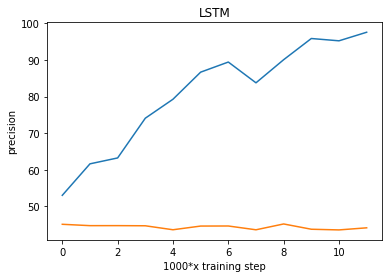

precision of the model on thevalidationdata: 43.506492614746094%
tensor([0.9981, 0.8096, 1.0000, 0.9934, 0.9985, 0.9929, 1.0000, 0.9928, 0.9998,
        0.9853, 0.9803, 0.9737, 0.9365, 0.9782, 0.8695, 0.6378, 0.9385, 0.9938,
        0.9752, 1.0000, 0.9096, 0.5833, 0.9632, 0.9860, 0.7400, 0.7588, 0.7028,
        0.9919, 0.9026, 0.6697, 0.9989, 0.9987, 0.9863, 0.9991, 0.7299, 0.9987,
        0.7160, 0.9964, 0.9516, 0.9974, 0.9498, 0.9999, 1.0000, 0.9974, 0.8712,
        0.9928, 0.9216, 0.8653, 0.9298, 0.9758, 0.9959, 0.9205, 0.6293, 0.8997,
        1.0000, 0.6358, 0.9338, 0.9926, 0.9847, 0.6262, 0.9295, 0.9937, 0.9986,
        0.9755, 0.9944, 0.5879, 0.8553, 0.9453, 0.7180, 0.9994, 1.0000, 0.9954,
        0.8621, 0.8734, 0.8373, 0.9706, 0.9959, 0.9997, 0.8926, 0.9771, 0.9970,
        0.9519, 0.9995, 0.9868, 0.9934, 0.5824, 0.8538, 0.9965, 0.9998, 1.0000,
        0.7513, 0.6146, 0.8955, 0.6870, 0.7001, 0.9755, 0.9863, 0.6518, 0.9709,
        0.9868], device='cuda:1')
current i is 2
Filter

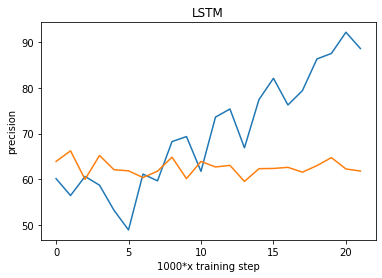

precision of the model on thevalidationdata: 61.832061767578125%
tensor([0.9621, 0.9913, 0.7166, 0.9317, 0.9729, 1.0000, 0.8090, 0.9345, 0.9986,
        0.9997, 0.9935, 0.9957, 0.9432, 0.6700, 0.6380, 0.9999, 0.5609, 0.5543,
        0.9429, 0.7536, 0.6404, 0.9982, 0.9992, 0.9635, 0.9965, 0.9887, 0.6262,
        0.6338, 0.8163, 0.5950, 0.6553, 0.9779, 0.9891, 0.9962, 0.5466, 0.9852,
        0.5863, 0.6657, 0.8343, 0.9980, 0.6220, 0.9307, 0.9524, 0.6592, 0.9997,
        0.9948, 0.9999, 0.8578, 0.7629, 0.7923, 0.7157, 0.9911, 0.9501, 0.9927,
        0.8861, 0.9525, 0.5861, 0.9174, 0.9977, 0.5442, 1.0000, 0.9860, 0.5941,
        0.6511, 0.6371, 0.9195, 0.7087, 0.8193, 0.9432, 0.7775, 0.9999, 0.9871,
        0.9117, 0.9818, 0.5509, 0.7068, 0.9727, 0.7078, 0.7373, 0.6176, 0.5904,
        0.8795, 0.8857, 0.9693, 0.9906, 0.6314, 0.5196, 0.9950, 0.9638, 0.9729,
        0.6223, 0.8503, 0.7711, 0.9992, 0.9622, 0.9978, 0.7211, 0.9997, 0.7137,
        0.9821], device='cuda:1')
current i is 3
Filter

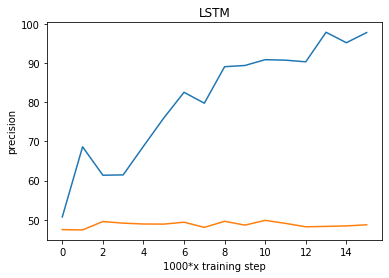

precision of the model on thevalidationdata: 48.965248107910156%
tensor([0.9991, 0.8942, 0.9999, 0.7792, 0.9228, 0.9367, 0.8625, 0.9993, 0.9996,
        1.0000, 0.9738, 0.6960, 0.9827, 0.8562, 0.6611, 0.9771, 0.6559, 0.9993,
        0.9810, 0.9994, 1.0000, 0.9209, 0.6448, 0.8303, 0.9889, 0.9970, 0.9651,
        0.9988, 0.9529, 0.9992, 0.9987, 0.8635, 0.7964, 0.9888, 0.9943, 0.9991,
        0.9999, 0.9990, 0.9969, 0.9979, 0.9999, 0.9959, 0.9999, 0.9907, 0.9960,
        0.8988, 0.9977, 0.9998, 0.9998, 0.9997, 0.9012, 0.9933, 0.9983, 0.9880,
        0.9791, 1.0000, 0.9999, 0.6046, 0.9915, 0.9939, 0.9983, 0.9997, 0.8885,
        0.9993, 0.9991, 0.8427, 0.9146, 0.9603, 0.9999, 0.9942, 0.9999, 0.9997,
        0.9996, 0.9999, 0.8876, 0.9189, 0.7119, 0.9975, 0.9996, 0.7350, 0.8816,
        0.5939, 0.8583, 0.9922, 0.8328, 0.8207, 0.9985, 0.9981, 0.9922, 0.9981,
        1.0000, 0.9958, 0.9996, 0.5636, 0.9676, 0.9983, 0.9978, 0.9973, 0.8845,
        0.7861], device='cuda:1')
current i is 5
Filter

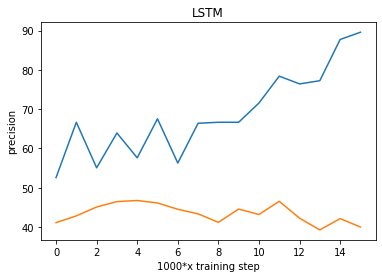

precision of the model on thevalidationdata: 42.014163970947266%
tensor([0.9960, 0.9836, 0.8641, 0.6605, 0.9987, 0.9886, 0.6358, 0.7119, 0.9982,
        0.9837, 0.9958, 0.8979, 0.9973, 0.9999, 0.9983, 0.9755, 0.5092, 0.9991,
        0.9993, 0.9799, 0.9391, 0.7736, 0.9769, 0.9508, 0.9968, 0.9997, 0.9997,
        0.9669, 0.6656, 0.6565, 0.6914, 0.9984, 0.5748, 0.9831, 0.9976, 0.9971,
        0.7106, 0.8715, 0.7855, 0.6270, 0.9683, 0.7104, 0.9995, 0.9997, 0.9995,
        0.9995, 0.9992, 0.6204, 0.9879, 0.8009, 0.9996, 0.7441, 0.7074, 0.9823,
        0.9703, 0.9990, 0.7373, 0.9591, 0.9984, 0.7109, 0.9981, 0.8639, 0.7304,
        0.9369, 0.5338, 0.6596, 0.9998, 0.9982, 0.9976, 0.9997, 0.6665, 0.9663,
        0.9983, 0.9995, 0.5476, 0.9925, 0.9954, 0.8703, 0.8533, 0.5019, 0.9982,
        0.9876, 0.9504, 0.9991, 0.9661, 0.8195, 0.8924, 0.9450, 0.9299, 0.5308,
        0.9631, 0.5388, 0.9925, 0.9989, 0.9290, 0.9981, 0.9841, 0.5064, 0.9856,
        0.8605], device='cuda:1')
current i is 6
Filter

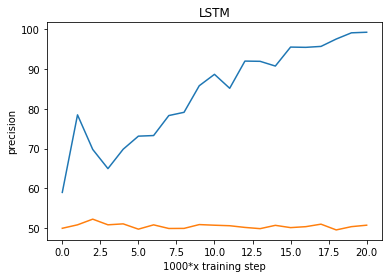

precision of the model on thevalidationdata: 50.99966049194336%
tensor([1.0000, 0.9999, 0.9995, 0.9519, 0.9830, 0.9999, 0.9974, 1.0000, 0.8956,
        0.9996, 0.9999, 0.9984, 1.0000, 0.9999, 0.8652, 1.0000, 0.9729, 0.6768,
        0.9996, 0.9988, 0.7777, 0.9995, 0.5774, 0.9995, 0.9998, 0.9999, 0.9996,
        0.9999, 0.9997, 0.9990, 0.5216, 0.9999, 0.9987, 0.9995, 0.8192, 0.9960,
        0.9793, 0.9812, 0.8016, 1.0000, 0.9992, 0.8281, 0.9816, 0.8453, 1.0000,
        1.0000, 0.9847, 0.8875, 0.9991, 0.5560, 0.9999, 0.7160, 0.9902, 0.9946,
        1.0000, 0.9561, 0.9982, 1.0000, 0.9993, 0.9187, 0.6900, 0.8730, 0.9947,
        0.9910, 0.9999, 0.7415, 0.9997, 0.9999, 0.9218, 1.0000, 0.9663, 1.0000,
        0.9985, 1.0000, 0.9651, 0.9980, 0.9971, 0.6141, 0.9999, 0.9948, 0.9999,
        0.9986, 0.9998, 0.8123, 1.0000, 0.9806, 0.9648, 0.6983, 0.9994, 0.6434,
        0.5838, 0.9991, 1.0000, 0.9902, 0.8446, 0.9248, 0.8875, 0.9831, 0.9714,
        1.0000], device='cuda:1')
current i is 7
Filter 

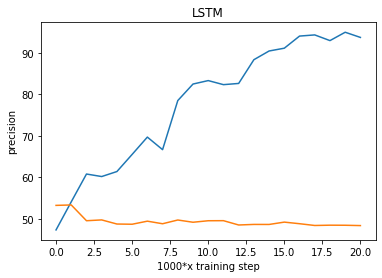

precision of the model on thevalidationdata: 48.374473571777344%
tensor([0.9978, 0.9755, 0.9962, 0.6356, 0.7303, 0.8125, 0.9893, 0.8941, 0.9999,
        0.9989, 1.0000, 0.9839, 0.9998, 0.9992, 0.9971, 0.9958, 0.9520, 0.9993,
        0.9363, 0.7528, 0.5273, 0.5079, 0.6366, 0.6036, 0.9987, 0.9965, 0.9991,
        0.8123, 0.9160, 0.8191, 0.9508, 0.9336, 0.9908, 0.9778, 0.5386, 0.5907,
        0.9874, 0.6659, 0.8739, 1.0000, 0.9997, 0.9813, 0.9998, 0.9999, 0.9974,
        0.9961, 0.6340, 0.9981, 0.5232, 0.9997, 0.9920, 0.9954, 0.9976, 0.8458,
        0.7911, 1.0000, 0.9948, 0.9988, 0.9162, 0.9658, 0.9758, 0.9953, 0.6871,
        0.7056, 0.8881, 0.8159, 0.9768, 0.9996, 0.9983, 0.7369, 0.9156, 0.5887,
        0.9946, 0.9639, 0.9901, 0.7154, 0.9969, 0.9991, 0.7074, 0.9950, 0.5272,
        0.9931, 0.9958, 0.9765, 0.9136, 0.9990, 0.9917, 0.9477, 0.9660, 0.9550,
        0.5091, 0.9989, 0.9493, 0.9991, 0.5215, 0.9788, 0.9999, 0.9976, 0.9351,
        0.9686], device='cuda:1')
current i is 8
Filter

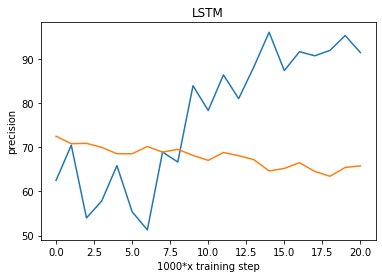

precision of the model on thevalidationdata: 64.96746063232422%
tensor([0.9052, 0.7699, 0.9997, 0.9449, 0.6438, 0.8135, 0.8675, 0.9972, 0.8468,
        0.7742, 0.9727, 0.6727, 0.5920, 0.5040, 0.5266, 0.8628, 0.9999, 0.9486,
        0.8052, 0.5401, 0.9128, 0.6306, 0.9996, 0.6651, 0.9208, 1.0000, 1.0000,
        0.6868, 0.6043, 0.5853, 0.7740, 0.9928, 0.5226, 0.6469, 0.9703, 0.8265,
        0.9989, 0.7754, 0.6436, 0.8126, 0.5605, 0.9808, 0.9996, 0.7554, 0.5757,
        0.6226, 0.5082, 0.6846, 0.5562, 0.9859, 0.9902, 0.5845, 0.7307, 0.9289,
        0.9773, 0.9967, 0.6595, 0.5399, 1.0000, 0.9948, 0.9426, 0.9987, 0.7100,
        0.7048, 0.5537, 0.5043, 0.6840, 0.9530, 0.6253, 0.9798, 0.6210, 0.9784,
        0.7329, 0.9991, 0.8529, 0.9999, 0.8525, 0.9824, 0.9862, 0.5593, 0.7252,
        1.0000, 0.7922, 0.6567, 0.9994, 0.6786, 0.9989, 0.9974, 0.9995, 0.6013,
        0.9905, 0.6139, 0.9827, 0.9342, 0.5833, 0.9158, 0.9556, 0.5910, 0.9347,
        0.9854], device='cuda:1')
current i is 9
Filter 

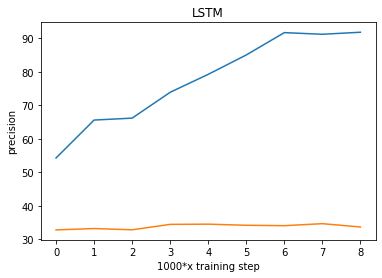

precision of the model on thevalidationdata: 33.66146469116211%
tensor([0.7595, 0.7798, 0.9115, 0.7340, 0.6161, 0.6051, 0.6392, 0.8990, 0.8757,
        0.9414, 0.8410, 0.9984, 0.7452, 0.5948, 0.9606, 0.9994, 0.9676, 0.5788,
        0.8098, 0.9999, 0.9573, 0.9998, 0.9992, 0.9772, 0.5073, 0.9518, 0.6253,
        0.5987, 0.9987, 0.9947, 0.9916, 0.9995, 0.9417, 0.9999, 0.9474, 0.8989,
        0.9952, 0.8173, 0.5877, 0.9397, 0.9201, 0.9993, 0.6103, 0.9995, 0.9983,
        0.9897, 0.9988, 0.6034, 0.8342, 0.9406, 0.9386, 0.7815, 0.9928, 0.8300,
        0.9888, 0.7574, 0.9995, 0.9087, 0.9589, 0.9999, 0.9287, 0.5768, 0.7087,
        0.5853, 0.8607, 0.9937, 0.7102, 0.9764, 0.9592, 0.9910, 0.9926, 0.7124,
        0.9122, 0.9337, 0.6836, 0.7032, 0.7450, 0.9993, 0.9991, 0.9767, 0.8910,
        0.7708, 0.7128, 0.6825, 0.9701, 0.9646, 0.9546, 1.0000, 0.9982, 0.8996,
        0.9970, 0.9994, 0.7998, 0.9643, 0.8449, 0.9860, 0.5172, 0.6318, 0.8606,
        0.6829], device='cuda:1')
current i is 10
Filter

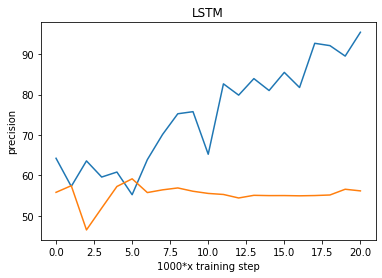

precision of the model on thevalidationdata: 56.00669860839844%
tensor([0.9999, 0.9621, 0.9997, 0.9992, 0.9997, 0.9974, 0.9862, 1.0000, 1.0000,
        0.9963, 0.9152, 1.0000, 0.8979, 0.7443, 0.9701, 0.9593, 0.9264, 0.9928,
        0.9029, 0.9766, 0.9946, 0.6265, 0.9998, 0.9930, 0.9995, 0.8504, 0.9990,
        0.9897, 0.9411, 1.0000, 0.8268, 0.9977, 0.9991, 0.7926, 0.5448, 0.9617,
        0.8750, 0.9971, 0.9988, 0.6788, 0.8653, 0.9998, 0.9961, 0.9990, 0.9920,
        0.9997, 0.8087, 0.9989, 0.9993, 0.7025, 0.9996, 0.9158, 0.9998, 0.9999,
        0.9801, 0.9401, 0.7067, 0.9944, 0.9999, 0.9966, 0.9994, 0.9974, 0.9999,
        0.9993, 0.9139, 0.9999, 0.9987, 0.9468, 0.9953, 0.9995, 0.9996, 0.6954,
        1.0000, 0.9200, 1.0000, 0.9978, 0.9436, 0.9993, 0.7750, 0.9184, 0.9757,
        0.9975, 0.9988, 0.8669, 0.5141, 0.9962, 0.9998, 0.5837, 0.9999, 0.9994,
        0.8798, 0.8039, 0.9994, 0.9944, 0.9995, 0.9998, 0.9970, 0.9947, 1.0000,
        0.9936], device='cuda:1')
current i is 11
Filter

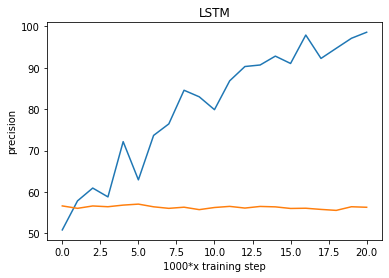

precision of the model on thevalidationdata: 55.842185974121094%
tensor([0.5867, 0.5517, 0.5901, 0.5157, 0.5037, 0.5413, 0.9912, 0.6055, 0.8965,
        0.8578, 0.9676, 0.9206, 0.9698, 0.9936, 0.7502, 0.6871, 0.9842, 0.7593,
        0.5936, 0.9822, 0.7114, 0.9637, 0.9872, 0.6645, 0.9240, 0.9853, 0.6256,
        0.5335, 0.5976, 0.6014, 0.6325, 0.6833, 0.5633, 0.7586, 0.9931, 0.9761,
        0.8135, 0.9940, 0.8110, 0.9965, 0.9932, 0.9993, 0.9815, 0.9083, 0.9368,
        0.9318, 0.9750, 0.9913, 0.9226, 0.6200, 0.6309, 0.9973, 0.9991, 0.9992,
        0.7862, 0.9984, 0.6701, 0.9789, 0.9997, 0.9998, 0.9613, 0.8440, 1.0000,
        0.7543, 0.5752, 0.7571, 0.9340, 0.9974, 0.9999, 0.9965, 0.9996, 0.6274,
        0.9873, 0.5075, 1.0000, 0.9697, 0.9964, 0.9998, 0.9877, 0.9999, 0.9922,
        0.9452, 0.7639, 0.7384, 0.9948, 0.8710, 0.9879, 0.9709, 0.8955, 0.6969,
        0.9983, 0.9983, 0.9997, 0.9643, 0.9775, 0.5771, 0.9984, 0.9994, 0.9972,
        0.9706], device='cuda:1')
current i is 12
Filte

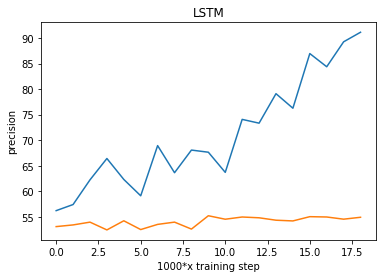

precision of the model on thevalidationdata: 54.34349060058594%
tensor([0.5326, 0.9142, 0.9947, 0.9855, 0.6510, 0.5152, 0.8905, 0.7842, 0.9769,
        0.9255, 0.7641, 0.9039, 0.8094, 0.7433, 0.9498, 0.9774, 0.8136, 0.9911,
        0.9972, 0.9733, 0.9099, 0.8228, 0.8717, 0.8924, 0.9766, 0.6946, 0.8616,
        0.6169, 0.6045, 0.9020, 0.8261, 0.9112, 0.9819, 0.9686, 0.7337, 0.6568,
        0.9970, 0.9983, 0.9961, 0.7931, 0.8099, 0.9190, 0.9576, 0.9599, 0.7289,
        0.5997, 0.6681, 0.8489, 0.8756, 0.9784, 0.9218, 0.8430, 0.6626, 0.8564,
        0.7670, 0.8066, 0.9961, 0.6152, 0.5964, 0.9174, 0.7144, 0.9634, 0.6690,
        0.8693, 0.7024, 0.7182, 0.7254, 0.5860, 0.8026, 0.9979, 0.8143, 0.9931,
        0.7009, 0.7665, 0.5725, 0.7627, 0.6669, 0.6275, 0.8873, 0.7505, 0.5734,
        0.7775, 0.9654, 0.9794, 0.9969, 0.5836, 0.9705, 0.8997, 0.7503, 0.6565,
        0.7676, 0.8165, 0.9999, 0.8120, 0.9030, 0.9715, 0.9537, 0.8745, 0.5778,
        0.9945], device='cuda:1')
current i is 13
Filter

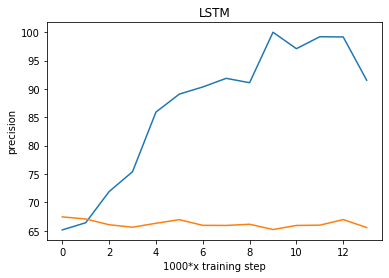

precision of the model on thevalidationdata: 65.32537078857422%
tensor([0.6540, 0.8174, 0.5033, 0.8628, 1.0000, 0.6379, 0.9997, 0.7448, 0.9994,
        0.9032, 0.5513, 0.9833, 0.9848, 1.0000, 0.9978, 0.7080, 0.5725, 0.7170,
        0.6916, 0.9906, 0.9396, 0.9998, 0.9664, 0.9998, 0.9408, 0.6966, 0.5311,
        0.9252, 1.0000, 0.5534, 0.5949, 0.5052, 0.5888, 0.9834, 0.6694, 0.9379,
        0.9125, 0.7757, 1.0000, 0.9998, 0.9974, 0.9998, 0.9985, 0.8912, 0.9354,
        0.9977, 0.9456, 0.9902, 0.5536, 0.9700, 0.5232, 0.7325, 0.7668, 0.5317,
        0.8691, 0.5372, 0.9781, 0.9986, 0.9953, 0.7941, 0.9997, 0.9878, 0.8822,
        0.8793, 0.9037, 0.6001, 0.9998, 0.9983, 0.9999, 0.9562, 0.9999, 0.9975,
        0.9189, 1.0000, 0.9762, 0.9581, 0.8211, 0.8382, 0.9993, 0.9952, 0.9999,
        0.9705, 0.9513, 0.9587, 0.9927, 0.8597, 0.8351, 0.9842, 0.9131, 0.9890,
        0.8621, 0.9997, 0.9891, 0.9842, 0.9999, 0.7741, 0.9519, 0.8042, 0.9957,
        0.6752], device='cuda:1')
current i is 15
Filter

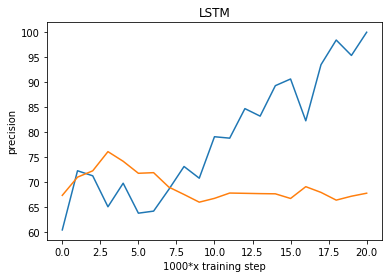

precision of the model on thevalidationdata: 67.7208251953125%
tensor([0.9992, 0.7875, 0.9952, 0.9901, 0.6248, 0.7152, 0.7470, 0.9998, 0.7152,
        0.9771, 0.9825, 0.9997, 0.5275, 0.8949, 0.9493, 0.8768, 0.9969, 0.9989,
        0.5915, 0.9967, 0.6178, 0.9833, 0.9995, 0.9996, 0.9971, 0.8067, 0.9981,
        0.9996, 0.9923, 0.7620, 0.9998, 0.8765, 0.9452, 0.9998, 0.5780, 0.7095,
        0.9886, 0.8070, 0.8124, 0.5873, 0.9209, 0.9968, 0.9439, 0.9998, 0.9984,
        0.9987, 0.9599, 0.9862, 0.9889, 0.9991, 0.9976, 0.6664, 0.8499, 0.9948,
        0.9778, 0.9362, 0.6984, 0.9980, 0.5192, 0.7468, 0.9992, 0.9991, 0.9912,
        0.5331, 0.5010, 0.9544, 0.9998, 0.9907, 0.6699, 0.9968, 0.9607, 0.9998,
        0.9076, 0.9409, 0.9902, 0.9949, 0.9924, 0.8160, 0.8526, 0.9993, 0.7843,
        0.9998, 0.9565, 0.9970, 0.9937, 0.6713, 0.9694, 0.9875, 0.9703, 0.9975,
        0.6852, 0.7719, 0.5918, 0.9704, 0.9999, 0.9989, 0.5639, 0.8662, 0.9982,
        0.9918], device='cuda:1')
current i is 16
Filter 

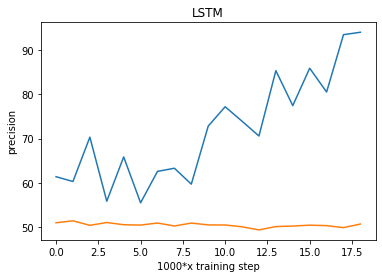

precision of the model on thevalidationdata: 50.7711296081543%
tensor([0.9871, 0.9953, 0.8744, 0.9646, 0.9944, 0.8406, 0.9788, 0.9923, 0.9995,
        0.9743, 0.7975, 0.9314, 0.9891, 0.9273, 0.7829, 0.9887, 0.7909, 0.9906,
        0.8709, 0.7949, 1.0000, 0.8222, 0.9977, 0.8361, 0.9821, 0.9939, 0.7832,
        0.5827, 0.9761, 0.9545, 0.8736, 0.9986, 0.8848, 0.9953, 0.9913, 0.8327,
        0.9371, 0.9784, 0.9948, 0.9953, 0.9785, 0.7846, 0.7981, 0.5981, 0.9728,
        0.7383, 0.9999, 0.9709, 0.7520, 0.9792, 0.6815, 0.9384, 0.9998, 0.5891,
        0.9962, 0.9993, 0.9678, 0.9852, 0.5690, 0.9896, 0.9809, 0.9034, 0.9721,
        0.9820, 0.8040, 0.9224, 0.5925, 0.8453, 0.9141, 0.8017, 0.8826, 0.9390,
        0.9415, 0.9427, 0.5995, 0.9822, 0.9948, 0.9998, 0.9722, 0.9150, 0.6376,
        0.5438, 0.9679, 0.9725, 0.9849, 0.9991, 0.9810, 0.7634, 0.9205, 0.9712,
        0.9791, 0.9858, 0.9989, 0.9700, 0.9909, 0.8363, 0.8023, 0.5294, 0.9158,
        0.9654], device='cuda:1')
current i is 17
Filter 

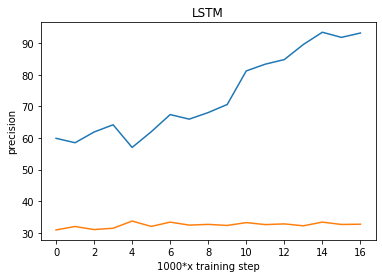

precision of the model on thevalidationdata: 33.13148880004883%
tensor([0.9995, 0.9955, 0.9955, 0.7974, 0.9730, 0.9892, 0.9450, 0.5548, 0.8010,
        0.6343, 0.9997, 0.7104, 0.9597, 0.9553, 0.9967, 0.9832, 0.7312, 0.9905,
        0.6065, 0.8353, 0.9882, 0.9981, 0.9661, 0.8746, 0.9369, 0.9084, 0.9658,
        0.9601, 0.6380, 0.9825, 0.9561, 0.9452, 0.9807, 0.9907, 0.6175, 0.8271,
        0.9611, 0.9997, 0.5169, 0.9999, 0.9910, 0.9556, 0.9873, 0.9990, 0.9752,
        0.9639, 0.9214, 0.8757, 0.9307, 0.9953, 0.9792, 0.9467, 0.8448, 0.9922,
        0.9961, 0.9699, 0.9951, 0.9997, 0.6139, 0.9430, 0.9999, 0.9999, 0.9975,
        0.9170, 0.9928, 0.6554, 0.6849, 0.9228, 0.6338, 0.8169, 0.9955, 0.7905,
        0.7614, 0.5195, 0.9791, 0.8047, 0.9075, 0.9987, 0.6089, 0.9997, 0.8035,
        0.8853, 0.9965, 0.7026, 0.9981, 0.9999, 0.8450, 0.9878, 0.7937, 1.0000,
        0.9980, 0.9802, 0.9404, 0.9984, 0.9997, 0.7989, 0.9693, 0.9997, 0.8104,
        0.8336], device='cuda:1')
current i is 18
Filter

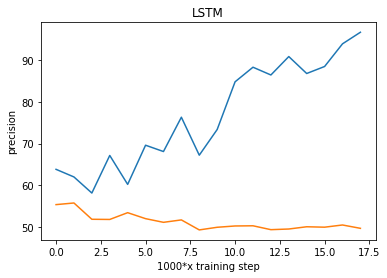

precision of the model on thevalidationdata: 49.15635681152344%
tensor([0.9981, 0.9956, 0.9997, 0.6055, 0.8392, 0.8144, 0.6492, 0.9512, 0.9293,
        0.7626, 0.7691, 0.9992, 0.9533, 0.9873, 0.7952, 0.9465, 0.9986, 0.9535,
        0.9740, 0.9859, 0.9973, 0.9975, 0.6277, 0.8247, 0.9914, 0.9904, 0.9929,
        0.9998, 0.9957, 0.7965, 0.9977, 0.9502, 0.9995, 0.9919, 0.9925, 0.8104,
        0.9968, 0.9991, 0.9990, 0.7268, 0.9982, 0.9994, 0.7328, 0.9126, 0.9905,
        0.9334, 0.8678, 0.9673, 0.9190, 0.8255, 0.6410, 0.9473, 0.8176, 0.9141,
        0.9226, 0.9987, 0.9891, 0.9991, 0.9815, 0.5549, 0.5194, 0.9993, 0.9661,
        0.5275, 0.6033, 0.9971, 0.7420, 0.9597, 0.9821, 0.8664, 0.7691, 0.9908,
        0.9663, 0.6327, 0.9712, 0.9995, 0.9098, 0.5159, 0.9703, 0.5516, 0.5104,
        0.9940, 0.5334, 0.9989, 0.9988, 0.7863, 0.8986, 0.6135, 0.9931, 0.9463,
        0.9749, 0.9982, 0.8846, 0.9336, 0.9117, 0.9270, 0.7318, 0.7995, 0.9997,
        0.9195], device='cuda:1')
current i is 19
Filter

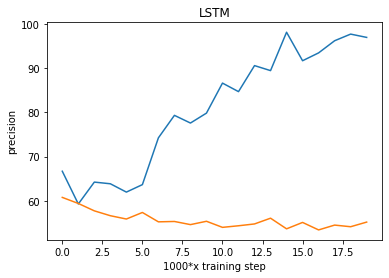

precision of the model on thevalidationdata: 54.16223907470703%
tensor([0.9868, 1.0000, 0.9690, 0.5084, 0.9997, 0.9995, 0.9899, 0.9961, 0.6213,
        0.9965, 0.9998, 0.9993, 0.7950, 0.9997, 0.9993, 0.6168, 0.5001, 0.9990,
        0.9871, 0.9975, 0.9419, 0.9284, 0.9736, 0.9698, 0.9741, 0.9736, 0.9877,
        0.9982, 0.9965, 0.9977, 0.9912, 1.0000, 0.9977, 0.9972, 0.9993, 0.5090,
        0.5342, 0.9985, 0.9423, 0.9790, 0.5843, 0.9998, 0.5834, 0.8576, 0.8192,
        0.9999, 0.8603, 0.6143, 0.8455, 0.8565, 0.9999, 0.9867, 0.9993, 0.9899,
        0.5982, 0.9551, 0.9169, 0.9782, 0.9994, 0.9999, 0.9993, 0.7197, 0.9992,
        0.9865, 0.9987, 0.9749, 0.8818, 0.9858, 0.8419, 0.9967, 0.9851, 1.0000,
        0.9995, 0.6702, 0.5906, 0.6647, 0.8403, 0.9811, 0.9910, 0.6221, 0.9845,
        0.9013, 1.0000, 0.9998, 0.9957, 0.9991, 0.9997, 0.7550, 0.6986, 0.9914,
        0.9897, 0.9999, 0.9964, 0.6673, 0.9733, 0.6899, 0.8272, 0.9990, 0.9998,
        0.9999], device='cuda:1')
current i is 20
Filter

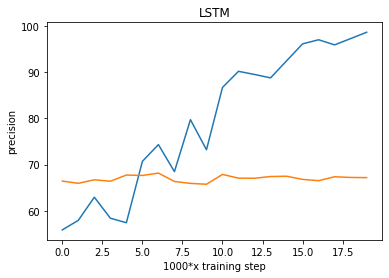

precision of the model on thevalidationdata: 67.11698150634766%
tensor([0.5160, 0.5141, 0.6524, 0.9387, 0.9816, 0.5147, 0.8545, 0.9869, 0.9737,
        0.9606, 0.9973, 0.9983, 0.9999, 0.9950, 1.0000, 0.9990, 0.9953, 0.9948,
        0.5782, 0.9371, 0.9982, 0.5602, 0.7675, 0.5669, 0.9955, 0.9933, 0.9964,
        0.9974, 0.8439, 0.5481, 0.9999, 0.6776, 0.9955, 0.9978, 0.6688, 0.9998,
        0.9999, 0.9985, 0.9828, 0.7430, 0.9965, 0.8732, 0.6095, 0.6427, 0.9298,
        0.9719, 0.9838, 0.9999, 0.9973, 0.9966, 0.9224, 0.5080, 0.7606, 0.7143,
        0.9992, 0.8208, 0.9984, 0.7849, 0.9368, 0.9152, 0.9985, 0.9999, 0.8438,
        0.9569, 0.7035, 0.9998, 0.9994, 0.7656, 0.9930, 0.9961, 0.9998, 0.9862,
        0.9974, 0.9885, 0.9993, 0.7981, 0.9621, 0.9871, 0.9947, 0.9998, 0.9968,
        0.9291, 0.9857, 0.9998, 0.9831, 0.9994, 0.7666, 0.9788, 0.9977, 0.9212,
        0.9958, 0.9895, 0.9991, 0.9673, 0.7667, 0.6065, 0.8737, 0.7501, 0.9948,
        0.9974], device='cuda:1')
current i is 21
Filter

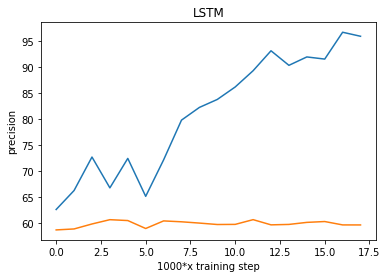

precision of the model on thevalidationdata: 60.07549285888672%
tensor([0.9996, 0.9983, 0.8036, 0.8094, 0.9341, 0.9960, 0.9179, 0.9999, 0.6939,
        0.9999, 1.0000, 0.9999, 0.9979, 0.9572, 0.9652, 0.8327, 0.9997, 0.9999,
        0.9111, 0.8619, 0.9971, 0.9978, 0.9065, 0.8977, 0.9997, 1.0000, 0.9905,
        0.9802, 0.5196, 0.9835, 0.7431, 0.9977, 0.8389, 0.9596, 0.9050, 0.9998,
        0.7817, 0.9843, 0.9999, 0.9931, 0.9274, 0.9694, 0.8306, 0.7817, 0.9996,
        0.9505, 0.9995, 1.0000, 0.9632, 0.6543, 0.9107, 0.9993, 0.9633, 0.9830,
        0.6759, 0.9895, 0.8193, 0.9993, 0.9991, 0.9882, 1.0000, 0.8737, 0.9220,
        1.0000, 0.9995, 1.0000, 0.9917, 0.8138, 0.6149, 0.7889, 0.9995, 0.7666,
        0.9380, 0.9936, 0.5398, 0.9998, 0.9972, 0.5050, 0.7361, 0.9881, 1.0000,
        0.9947, 0.9999, 0.9996, 0.9869, 0.8936, 0.9923, 0.5444, 0.6903, 0.9985,
        1.0000, 0.9559, 0.9898, 0.9646, 0.5466, 0.9916, 0.8829, 0.9995, 1.0000,
        0.9378], device='cuda:1')
current i is 22
Filter

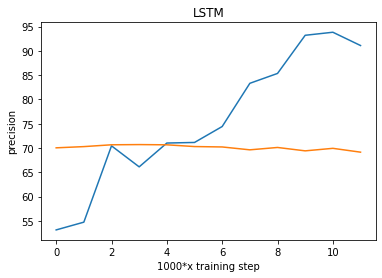

precision of the model on thevalidationdata: 69.15458679199219%
tensor([0.9817, 0.7732, 0.6536, 0.9189, 0.5648, 0.5270, 0.8454, 0.9996, 0.8741,
        0.9248, 0.9901, 0.5299, 0.8629, 0.6823, 0.5543, 0.7489, 0.6938, 0.9163,
        0.9981, 0.5958, 0.7100, 0.9528, 0.9889, 0.9994, 0.9950, 0.5822, 0.8136,
        0.7993, 0.8701, 0.6047, 0.5257, 0.5333, 0.7008, 0.6947, 0.7838, 0.7038,
        0.5817, 0.5888, 0.6529, 0.6629, 0.5661, 0.5515, 0.5613, 0.9996, 0.5799,
        0.9984, 0.7294, 0.7761, 0.6692, 0.9992, 0.6506, 0.5626, 0.7014, 0.9081,
        0.7953, 0.5391, 0.5508, 0.5721, 0.8941, 0.6224, 0.6053, 0.7083, 0.9997,
        0.7351, 0.9958, 0.8532, 0.9953, 0.5759, 0.5454, 0.5379, 0.6771, 0.7097,
        0.6461, 0.6662, 0.5781, 0.8638, 0.7877, 0.9990, 0.5713, 0.5478, 0.5295,
        0.5279, 0.5255, 0.5142, 0.5209, 0.5037, 0.9358, 0.9758, 0.6462, 0.7868,
        0.5024, 0.9719, 0.9399, 0.9820, 0.9725, 0.9182, 0.9422, 0.9273, 0.5095,
        0.7752], device='cuda:1')
current i is 23
Filter

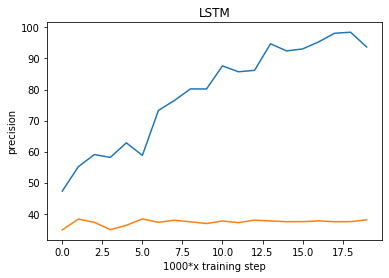

precision of the model on thevalidationdata: 39.28571319580078%
tensor([0.9184, 0.9168, 0.9963, 0.9916, 1.0000, 0.8513, 1.0000, 0.7443, 1.0000,
        0.7574, 0.8170, 0.9584, 0.9717, 0.9485, 0.9808, 0.9301, 0.9727, 0.7279,
        0.9977, 0.5030, 0.9474, 0.7222, 0.9798, 0.9785, 0.8398, 0.9897, 0.9005,
        0.9881, 0.9999, 0.9891, 0.5167, 0.7236, 0.9880, 0.9927, 0.9631, 0.5970,
        0.9958, 0.9869, 0.9991, 0.9732, 0.9869, 0.9339, 0.9990, 0.9999, 0.9977,
        0.9973, 0.6451, 0.9998, 0.9965, 0.9975, 0.9954, 0.9995, 1.0000, 0.9986,
        0.7666, 0.9923, 1.0000, 0.7231, 0.9999, 0.9747, 0.7262, 0.9830, 0.8919,
        0.9878, 0.9931, 0.9776, 0.9957, 0.9374, 0.9994, 0.5915, 0.7532, 0.9328,
        0.9901, 0.9997, 0.9906, 0.9556, 0.9960, 0.9999, 0.9946, 0.9819, 0.9998,
        0.9996, 0.9996, 0.7928, 0.9515, 0.9847, 0.9999, 0.9084, 0.9997, 0.9852,
        1.0000, 0.9957, 0.9993, 0.9989, 0.9998, 0.9984, 0.7641, 0.8973, 0.9986,
        0.9166], device='cuda:1')
current i is 24
Filter

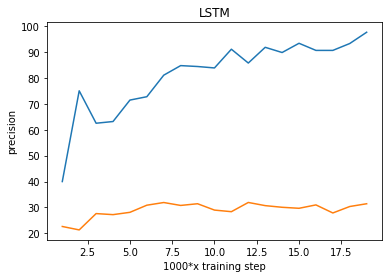

precision of the model on thevalidationdata: 29.61188316345215%
tensor([0.9886, 0.9997, 0.9999, 0.9997, 0.6144, 0.9991, 0.7522, 0.9172, 0.7209,
        0.9981, 0.8124, 0.7186, 0.9587, 0.9885, 0.9998, 0.9904, 0.7507, 0.9987,
        0.9306, 1.0000, 0.5390, 0.9999, 0.9998, 0.9999, 0.9999, 0.9889, 0.9944,
        0.9994, 0.9978, 0.6765, 0.9995, 0.9999, 0.6985, 0.9958, 0.6841, 0.8692,
        0.7584, 0.8019, 0.6418, 0.9913, 0.9985, 0.9141, 0.9953, 0.9987, 0.9123,
        0.9658, 0.6352, 0.9046, 0.9792, 0.9999, 0.9999, 0.9973, 0.9999, 0.9999,
        0.7196, 0.7365, 0.5391, 0.7184, 0.6613, 0.6042, 0.9972, 0.9997, 0.9999,
        1.0000, 0.7944, 0.7175, 0.9984, 0.9999, 1.0000, 0.9991, 0.7562, 0.6208,
        0.7824, 0.9997, 0.9933, 0.9870, 0.9696, 0.9997, 0.9992, 0.9248, 0.6813,
        0.9891, 0.9998, 0.7545, 0.9986, 0.9999, 0.9639, 0.9900, 0.9903, 0.9581,
        0.9977, 0.6261, 0.9926, 0.9843, 0.9836, 0.9884, 0.9977, 0.9898, 0.9489,
        0.9395], device='cuda:1')
current i is 25
Filter

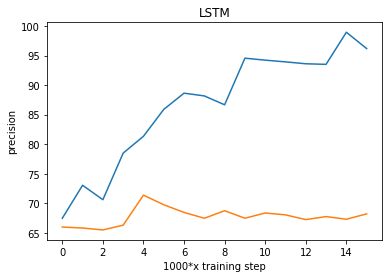

precision of the model on thevalidationdata: 68.86543273925781%
tensor([0.9747, 0.9990, 0.9954, 0.9991, 0.9966, 0.9985, 0.8576, 0.9023, 0.8366,
        0.9891, 0.9998, 0.9990, 0.8719, 1.0000, 1.0000, 0.9986, 0.9989, 0.9983,
        1.0000, 0.9963, 0.9987, 0.9929, 0.9897, 0.9980, 1.0000, 0.9700, 0.9998,
        0.9998, 0.9827, 0.5635, 1.0000, 0.9993, 0.9989, 0.9453, 0.9962, 0.8386,
        0.5001, 0.9997, 0.9240, 0.9825, 0.9996, 0.9905, 0.9895, 0.9996, 0.7627,
        0.6777, 0.5973, 0.9726, 0.9999, 0.9706, 0.8397, 0.8900, 0.8893, 0.9997,
        0.8764, 0.9927, 0.9732, 0.9010, 0.9997, 0.9996, 0.9997, 0.9991, 0.9999,
        1.0000, 1.0000, 0.7224, 0.9906, 0.9973, 0.9998, 0.9999, 0.9715, 1.0000,
        0.9994, 0.9999, 0.8916, 0.9945, 0.9464, 0.7221, 0.9994, 0.9992, 0.9994,
        0.9998, 1.0000, 0.5258, 0.9931, 0.9847, 0.9991, 1.0000, 0.9958, 0.9975,
        0.8938, 0.9357, 0.9993, 0.9950, 1.0000, 0.9999, 0.7638, 0.9018, 0.9637,
        0.9998], device='cuda:1')
current i is 26
Filter

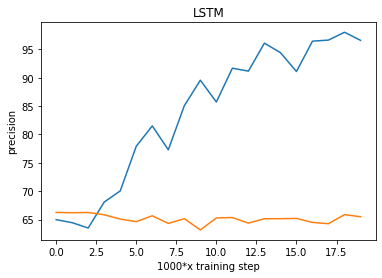

precision of the model on thevalidationdata: 65.2228775024414%
tensor([0.9490, 0.9986, 0.9987, 0.9590, 0.9306, 0.9994, 0.9999, 1.0000, 0.9999,
        0.9982, 1.0000, 0.9955, 0.7837, 0.7937, 0.9991, 0.9999, 0.9996, 0.9600,
        0.9990, 0.6173, 0.9298, 0.6590, 1.0000, 0.9962, 0.6331, 0.9627, 0.9995,
        0.9745, 1.0000, 0.9994, 0.9919, 0.9942, 0.9999, 0.9994, 0.9988, 1.0000,
        0.8157, 0.9831, 0.9857, 0.7646, 0.9342, 0.5786, 0.9955, 0.9876, 0.9914,
        0.9998, 0.8227, 0.9965, 0.9980, 0.6434, 0.9927, 0.9631, 0.5602, 0.9949,
        1.0000, 0.9964, 0.9973, 0.9970, 1.0000, 0.5251, 0.9052, 0.9999, 0.8058,
        0.9816, 0.9975, 0.9802, 0.7571, 1.0000, 0.9979, 0.9556, 0.8819, 0.9541,
        0.9844, 0.9657, 0.7392, 0.9990, 0.7615, 0.7344, 0.9594, 0.9389, 0.9959,
        0.8448, 1.0000, 0.9992, 0.8856, 0.6548, 0.9182, 0.7650, 0.9997, 0.9999,
        0.5759, 1.0000, 0.9677, 0.9999, 0.9998, 0.9942, 0.9911, 1.0000, 1.0000,
        0.9980], device='cuda:1')
current i is 27
Filter 

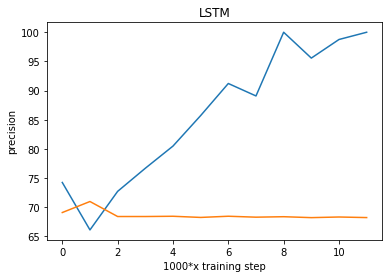

precision of the model on thevalidationdata: 68.23583221435547%
tensor([0.9962, 0.9913, 0.9973, 0.9992, 0.9978, 0.9999, 0.9513, 0.9997, 0.9477,
        0.9865, 0.5367, 0.9997, 0.9967, 0.6724, 0.9981, 0.9980, 0.9986, 0.9174,
        0.9836, 0.9762, 0.9876, 0.5951, 0.7082, 0.7433, 0.9905, 0.9251, 0.9961,
        0.9685, 0.7059, 0.9967, 0.6335, 0.9998, 0.9989, 0.9975, 0.8974, 0.9952,
        0.9975, 0.9997, 0.5632, 0.9908, 0.9949, 0.9998, 0.7267, 0.9971, 0.8962,
        0.9738, 0.9991, 0.9997, 0.9955, 0.8170, 0.5385, 0.9998, 0.9412, 0.9998,
        0.9082, 0.8764, 0.9949, 0.9981, 1.0000, 0.9947, 0.9995, 0.9801, 0.9083,
        0.9306, 0.9964, 0.9657, 0.9862, 0.9994, 0.6303, 0.9326, 0.9964, 0.7667,
        0.9500, 0.9964, 0.9534, 0.9942, 0.9984, 0.9988, 0.9997, 0.9953, 0.9549,
        0.9161, 0.9984, 0.9969, 0.9997, 0.9941, 0.9997, 0.9996, 0.9661, 0.7680,
        0.9593, 0.9958, 0.8681, 0.9848, 0.9986, 0.5462, 0.6510, 0.9143, 0.6782,
        0.9610], device='cuda:1')
current i is 28
Filter

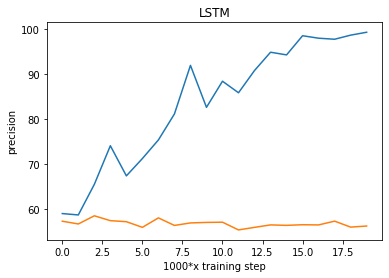

precision of the model on thevalidationdata: 55.8060417175293%
tensor([0.9998, 0.9872, 0.9964, 0.8732, 0.9883, 0.5605, 1.0000, 0.9637, 0.7335,
        0.9532, 0.8252, 0.9988, 0.9081, 0.6222, 0.9992, 1.0000, 1.0000, 0.9943,
        1.0000, 0.6855, 0.9857, 0.9995, 0.9954, 0.9998, 0.9941, 0.9624, 0.9830,
        1.0000, 0.9867, 0.5284, 0.7349, 0.9729, 0.9991, 0.9611, 0.9385, 0.9999,
        0.9997, 1.0000, 0.9555, 0.9971, 0.9781, 0.9960, 0.9852, 0.9813, 0.9994,
        0.9527, 0.9994, 0.9953, 0.9817, 0.9998, 0.9934, 0.7062, 0.6110, 0.9986,
        0.8575, 0.9997, 0.9531, 0.5447, 0.9985, 0.9900, 0.8544, 0.7218, 0.9992,
        0.9986, 0.8999, 0.9933, 0.6262, 1.0000, 0.9998, 0.9821, 0.7950, 0.9772,
        0.6736, 0.9150, 0.5433, 0.7793, 0.6415, 1.0000, 0.9128, 0.9696, 0.9999,
        1.0000, 0.9783, 0.9544, 0.9996, 0.9992, 0.8390, 0.9738, 0.5017, 0.9768,
        0.9325, 0.9989, 0.9977, 0.5337, 0.9066, 0.8283, 0.9988, 0.9982, 0.8620,
        0.9435], device='cuda:1')
current i is 29
Filter 

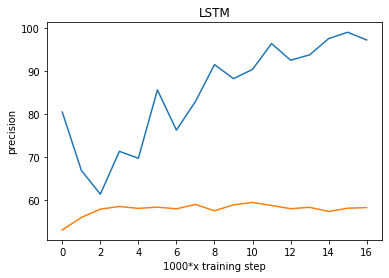

precision of the model on thevalidationdata: 58.876220703125%
tensor([0.9952, 0.9988, 0.7153, 0.7163, 0.9963, 0.9820, 0.7207, 0.6330, 1.0000,
        0.7402, 0.5305, 0.9418, 0.8649, 0.6412, 0.5992, 0.5381, 0.9696, 0.9831,
        0.9985, 0.6557, 0.9910, 0.6187, 0.8247, 0.9996, 0.5363, 0.8882, 0.9633,
        0.9991, 0.9997, 0.8899, 0.8984, 0.8586, 0.8884, 0.5227, 0.6767, 0.7557,
        0.9932, 0.9991, 0.9974, 0.8535, 0.9998, 0.8824, 0.7907, 0.9696, 0.6658,
        0.6748, 0.6898, 0.5925, 0.9766, 0.8373, 0.7215, 0.8696, 0.7337, 0.6596,
        0.9996, 0.9311, 0.9872, 0.6332, 0.8414, 0.6812, 0.5285, 0.9974, 1.0000,
        0.7036, 0.6181, 0.7060, 0.6392, 0.9962, 0.6126, 0.9486, 0.8993, 0.9982,
        0.8331, 0.9988, 0.9999, 0.8858, 0.9421, 0.5899, 0.9986, 0.9930, 0.9363,
        0.9962, 0.7411, 0.9998, 0.8905, 0.9901, 0.9604, 0.9997, 0.9773, 0.5649,
        0.5373, 0.9385, 0.5121, 0.6616, 0.7023, 0.6119, 0.9864, 0.9999, 0.9098,
        0.9995], device='cuda:1')
current i is 30
Filter l

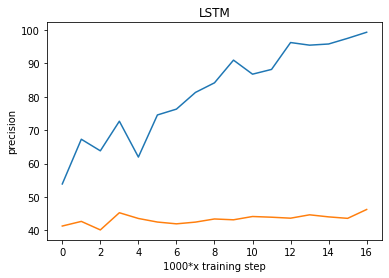

precision of the model on thevalidationdata: 44.74839401245117%
tensor([0.9989, 0.9992, 0.9998, 0.9997, 0.9992, 0.9096, 0.9935, 0.6614, 0.8696,
        1.0000, 0.8552, 0.9986, 0.9657, 0.9982, 0.6727, 0.8941, 0.6072, 0.9865,
        0.9851, 0.9972, 0.9691, 0.9999, 0.9999, 0.9925, 0.9984, 0.8283, 0.9989,
        0.9995, 0.8155, 0.9298, 0.9911, 0.9948, 0.6835, 0.9886, 0.9993, 0.9996,
        0.9998, 0.9800, 0.9988, 0.9997, 0.9978, 0.9973, 1.0000, 0.9971, 0.9597,
        0.9979, 1.0000, 0.6073, 0.9830, 0.9998, 0.7401, 0.9983, 0.9999, 0.9986,
        0.8983, 0.9982, 0.7891, 0.9999, 0.5339, 0.9998, 0.6768, 0.9972, 1.0000,
        0.9209, 0.9916, 0.9980, 0.9980, 0.9796, 0.9522, 0.9045, 0.9998, 0.9991,
        0.9930, 0.9991, 0.8011, 0.9996, 0.9715, 0.7344, 0.9995, 0.9984, 0.9124,
        0.9973, 0.9602, 0.9842, 0.9998, 0.9278, 0.9955, 0.9987, 1.0000, 0.9953,
        0.9518, 0.8059, 0.9944, 0.9919, 0.9981, 0.9958, 0.9984, 0.9912, 0.9944,
        0.9997], device='cuda:1')
current i is 31
Filter

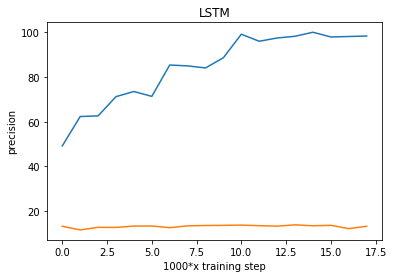

precision of the model on thevalidationdata: 12.671703338623047%
tensor([0.9983, 0.9948, 0.7497, 0.8452, 0.9956, 0.6424, 0.8587, 0.9983, 0.9248,
        0.9843, 0.9984, 0.9999, 0.9950, 1.0000, 0.9494, 1.0000, 0.5948, 0.9999,
        0.9978, 1.0000, 0.9979, 0.5236, 0.9826, 0.9999, 0.9171, 0.9944, 0.9952,
        0.7632, 0.9650, 0.9800, 0.9756, 0.9952, 0.9942, 0.9765, 0.9989, 0.9922,
        0.9999, 0.9991, 0.5327, 0.6880, 0.9999, 0.9969, 1.0000, 0.7225, 0.9889,
        0.9980, 0.9999, 0.9777, 1.0000, 0.9938, 0.9989, 0.9943, 0.9995, 0.9947,
        0.9888, 0.9838, 0.9779, 0.9728, 0.9995, 0.9997, 0.9961, 0.9995, 1.0000,
        1.0000, 0.9196, 0.7592, 0.9591, 0.9970, 0.9999, 0.9964, 1.0000, 0.9846,
        0.9998, 0.9997, 0.9965, 0.9911, 0.9685, 0.9992, 0.5544, 0.9999, 0.9061,
        0.9940, 0.7192, 0.9926, 0.9985, 0.9971, 0.8704, 0.9265, 0.9953, 0.5394,
        0.5395, 0.9972, 0.8181, 0.7628, 0.9996, 0.9988, 0.6102, 0.7192, 0.9152,
        0.9980], device='cuda:1')
current i is 32
Filte

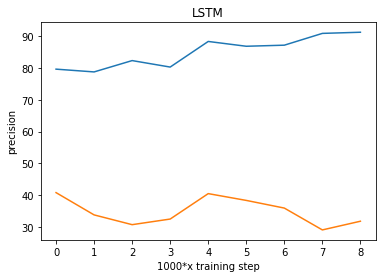

precision of the model on thevalidationdata: 29.579208374023438%
tensor([0.9754, 0.9437, 0.9851, 0.9236, 0.9996, 0.9979, 0.9889, 0.9981, 0.9967,
        0.5646, 0.9856, 0.9996, 0.6817, 0.9980, 0.6967, 0.9518, 0.9988, 0.6857,
        0.9354, 0.9720, 0.5762, 0.9587, 0.7822, 0.7083, 0.9916, 0.9944, 0.8983,
        0.9899, 0.9996, 0.8569, 0.5792, 0.6333, 0.9540, 0.9945, 0.9998, 0.5284,
        0.9971, 0.9984, 0.8758, 0.7594, 0.9577, 0.7732, 0.8696, 0.9992, 0.9232,
        0.8327, 0.9817, 0.9989, 0.9985, 0.9912, 0.8452, 0.9801, 0.8761, 0.9970,
        0.9992, 0.9999, 0.9809, 0.9265, 0.9669, 0.9664, 0.9963, 0.9997, 0.9835,
        0.9696, 0.9998, 0.8684, 0.8256, 0.9961, 0.9899, 0.8574, 0.9993, 0.9784,
        0.5154, 0.6497, 0.9231, 0.9974, 0.9997, 0.9853, 0.9874, 0.9908, 0.9778,
        0.9522, 0.5730, 0.9993, 0.9993, 0.9991, 0.9528, 0.9318, 0.9951, 0.9084,
        0.6126, 0.9995, 0.8447, 0.9982, 0.9992, 0.9822, 0.5954, 0.9403, 0.9850,
        0.9978], device='cuda:1')
current i is 33
Filte

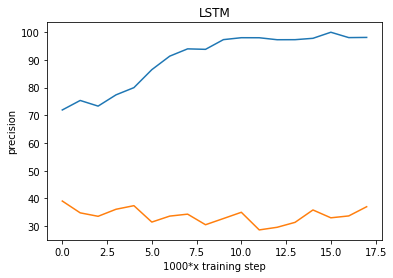

precision of the model on thevalidationdata: 37.00957489013672%
tensor([0.9552, 0.9978, 0.9974, 0.9844, 0.9994, 1.0000, 0.8502, 1.0000, 1.0000,
        0.8996, 1.0000, 0.9999, 0.8353, 0.9984, 0.9998, 1.0000, 0.9706, 0.9812,
        0.9763, 0.9996, 0.9973, 0.6868, 0.9459, 0.8685, 0.8287, 0.5454, 0.9996,
        0.7441, 0.9930, 0.8891, 1.0000, 1.0000, 0.9928, 0.8865, 0.9999, 0.9909,
        0.9993, 0.8946, 0.6997, 1.0000, 0.9998, 0.5421, 0.9859, 1.0000, 0.9805,
        0.9982, 1.0000, 0.9997, 0.9998, 0.9998, 0.9751, 0.9706, 0.9695, 1.0000,
        0.9982, 0.9907, 0.9996, 0.7870, 0.5146, 0.9452, 0.9995, 1.0000, 0.9992,
        0.7906, 0.6586, 0.8301, 1.0000, 0.9997, 0.9992, 0.9431, 0.9640, 0.9997,
        1.0000, 0.8964, 0.9180, 0.9981, 0.9426, 1.0000, 0.9978, 0.9999, 0.8633,
        0.9912, 0.9995, 0.9993, 0.9998, 0.9990, 0.7948, 1.0000, 0.8194, 0.9939,
        0.9949, 0.9999, 1.0000, 0.9583, 0.5709, 0.7831, 0.6807, 0.9998, 0.8757,
        0.9716], device='cuda:1')
current i is 34
Filter

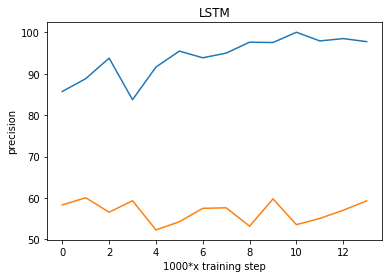

precision of the model on thevalidationdata: 56.02641677856445%
tensor([0.6896, 0.9995, 0.9996, 0.9999, 0.9994, 1.0000, 0.9944, 0.9999, 0.9977,
        0.9993, 1.0000, 0.7988, 1.0000, 0.9985, 0.9893, 0.8580, 0.9892, 0.9944,
        1.0000, 1.0000, 0.9998, 1.0000, 1.0000, 0.9994, 0.9388, 0.9948, 0.9881,
        0.9995, 0.9997, 1.0000, 1.0000, 0.9997, 0.9932, 0.9421, 0.6171, 0.9966,
        0.9994, 0.9999, 0.6381, 1.0000, 1.0000, 0.9915, 1.0000, 1.0000, 0.8743,
        0.9999, 1.0000, 0.7633, 0.6611, 1.0000, 0.9985, 1.0000, 0.9990, 0.9997,
        0.9998, 0.9134, 0.9817, 0.9946, 0.9159, 0.9978, 0.9996, 0.8795, 0.9983,
        0.9999, 0.8125, 0.9983, 0.9999, 0.9992, 0.9998, 0.9999, 0.7673, 0.9999,
        0.9992, 0.9999, 0.9997, 0.9998, 1.0000, 0.9998, 0.9973, 0.9999, 0.8674,
        1.0000, 0.9981, 0.7324, 1.0000, 0.9998, 0.9652, 0.9998, 0.7488, 0.9999,
        1.0000, 0.9994, 0.9997, 0.9999, 1.0000, 0.9999, 0.9993, 0.9984, 0.5888,
        0.9996], device='cuda:1')
current i is 35
Filter

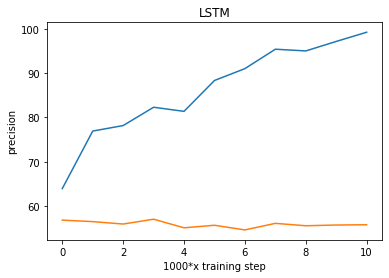

precision of the model on thevalidationdata: 55.750423431396484%
tensor([0.9910, 0.9996, 0.9954, 0.9996, 0.9626, 0.9998, 0.9884, 0.9183, 0.6308,
        0.9437, 0.7165, 0.7614, 0.9998, 0.9996, 0.9093, 0.8982, 0.9932, 0.9990,
        0.9557, 0.9065, 0.9986, 0.9776, 0.9952, 0.9996, 0.9853, 0.9999, 0.9965,
        0.9996, 0.6116, 0.8313, 0.9935, 1.0000, 0.9988, 0.9032, 0.9703, 0.9989,
        0.9995, 0.9990, 0.9994, 1.0000, 0.5094, 0.9494, 0.9999, 0.9998, 1.0000,
        0.9873, 0.9987, 0.9956, 0.9999, 0.9982, 0.9602, 0.9774, 0.9993, 1.0000,
        0.9979, 0.9991, 1.0000, 0.9906, 0.9999, 0.5107, 0.9963, 0.9667, 0.9854,
        0.8758, 0.9998, 0.9699, 0.9960, 0.9857, 0.9940, 0.9996, 0.9570, 0.9999,
        0.6673, 0.9979, 0.9985, 1.0000, 0.9497, 0.9946, 0.5411, 0.9881, 0.9727,
        0.9967, 0.9030, 1.0000, 0.9991, 0.9271, 0.9801, 0.9926, 0.5450, 0.9874,
        1.0000, 0.9997, 0.9998, 0.9683, 0.9998, 1.0000, 0.9997, 0.9990, 0.9780,
        0.9489], device='cuda:1')
current i is 36
Filte

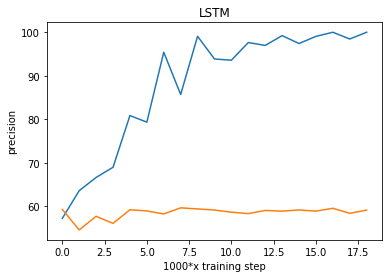

precision of the model on thevalidationdata: 57.61741256713867%
tensor([0.9472, 0.9903, 0.9592, 0.9998, 0.9999, 0.9998, 0.9927, 0.9988, 0.9999,
        0.9706, 0.6011, 1.0000, 0.8390, 0.9127, 0.9925, 1.0000, 0.9985, 0.9991,
        0.9979, 0.9998, 0.6691, 0.9931, 0.9999, 0.8726, 0.9950, 0.7241, 0.8706,
        0.9993, 0.9936, 0.9929, 0.9710, 0.9824, 0.9998, 0.9999, 0.9543, 0.6038,
        0.9960, 0.9954, 0.9960, 0.9485, 1.0000, 0.9884, 0.9996, 0.9994, 0.9999,
        0.6579, 0.9812, 0.8402, 0.9954, 0.5124, 0.9660, 1.0000, 0.9996, 0.9899,
        0.8678, 0.9325, 0.9999, 0.9751, 0.9941, 0.9960, 0.9973, 0.9733, 0.9999,
        0.9999, 0.9973, 0.9999, 1.0000, 0.9972, 0.9004, 0.9951, 0.9111, 0.9975,
        0.9999, 0.8158, 0.9881, 0.9999, 0.9999, 0.9932, 0.9999, 0.9995, 0.7551,
        0.9827, 0.8742, 1.0000, 0.9983, 0.9999, 0.9994, 0.9994, 0.9866, 0.9153,
        0.9335, 0.5262, 0.8158, 0.9625, 0.9610, 0.9159, 0.9998, 0.8161, 0.7997,
        0.8976], device='cuda:1')
current i is 37
Filter

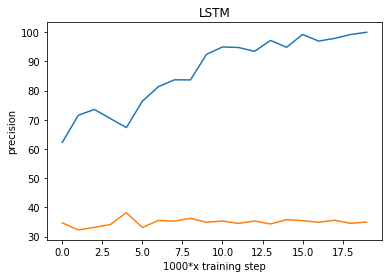

precision of the model on thevalidationdata: 35.34743118286133%
tensor([0.9945, 0.8854, 0.9987, 0.9998, 0.9950, 0.9995, 0.9906, 0.9804, 0.7404,
        0.6652, 0.9977, 0.9937, 0.9975, 0.9609, 0.6032, 0.7981, 0.9992, 0.5069,
        0.9459, 0.9140, 0.9996, 0.8781, 0.9991, 0.9402, 0.9994, 0.9993, 0.9999,
        1.0000, 0.9814, 0.9263, 0.9199, 0.9818, 0.9927, 0.8621, 0.9793, 1.0000,
        0.9999, 0.9985, 1.0000, 0.9996, 0.9050, 0.9822, 0.9960, 0.5954, 0.9991,
        0.9994, 0.9958, 0.9994, 0.5999, 0.6378, 0.8626, 0.6315, 0.9974, 0.8431,
        1.0000, 0.9785, 0.8724, 0.8202, 1.0000, 0.9846, 0.9983, 0.6399, 0.9971,
        0.9297, 0.9995, 0.9958, 0.8590, 0.9709, 0.8327, 0.9963, 0.9953, 1.0000,
        0.9613, 0.9382, 0.9990, 0.9998, 0.9249, 0.9998, 0.6943, 0.8744, 0.9055,
        0.9955, 0.9984, 0.9895, 0.9571, 0.7181, 0.9924, 0.9982, 0.9946, 0.9878,
        0.6226, 0.9516, 0.7313, 0.8817, 0.5891, 1.0000, 0.9994, 0.9991, 0.9935,
        0.9950], device='cuda:1')
current i is 38
Filter

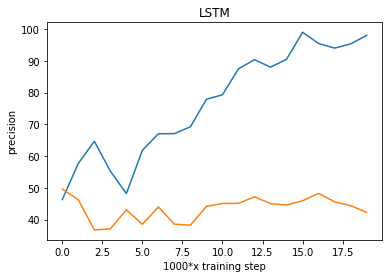

precision of the model on thevalidationdata: 42.29166793823242%
tensor([0.8738, 0.6929, 0.6918, 0.9974, 0.9998, 0.9939, 0.9930, 0.9999, 0.9990,
        0.9945, 1.0000, 0.9988, 0.9994, 0.9942, 0.9985, 0.9974, 0.9999, 0.9976,
        0.9979, 0.9997, 0.9981, 0.9977, 0.9996, 0.9980, 0.9944, 1.0000, 0.9980,
        0.9976, 0.9999, 0.9943, 0.9979, 0.9995, 0.9978, 0.9969, 0.9994, 0.9976,
        0.9941, 1.0000, 0.9960, 0.9974, 0.9997, 0.9989, 0.9970, 1.0000, 0.9997,
        0.9959, 0.9999, 0.9993, 0.9991, 0.9996, 0.9988, 0.9703, 0.9997, 1.0000,
        0.9995, 0.9999, 0.9993, 0.9986, 0.9978, 0.9997, 0.9964, 0.9998, 0.9994,
        0.9961, 0.9999, 0.9998, 0.9557, 1.0000, 0.9930, 0.9992, 0.9999, 0.9994,
        0.9963, 1.0000, 0.8602, 0.9963, 0.9999, 0.9956, 0.9466, 0.9999, 0.9497,
        0.9971, 1.0000, 0.9992, 0.9997, 1.0000, 1.0000, 0.9975, 0.9992, 0.9988,
        0.9996, 1.0000, 0.9991, 0.9999, 0.9992, 0.9987, 0.9831, 1.0000, 1.0000,
        0.9455], device='cuda:1')
current i is 39
Filter

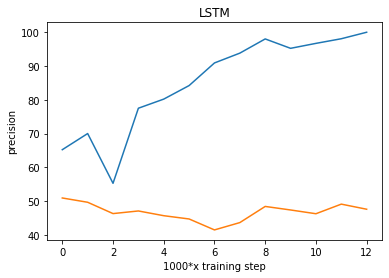

precision of the model on thevalidationdata: 46.83072280883789%
tensor([0.9176, 1.0000, 0.9217, 0.9674, 0.8388, 0.5863, 0.9947, 1.0000, 1.0000,
        0.9876, 0.6715, 0.9980, 0.9994, 0.8124, 1.0000, 0.9685, 0.9144, 0.9998,
        0.7781, 0.6284, 0.9511, 0.9997, 0.9995, 1.0000, 1.0000, 0.8897, 0.9873,
        1.0000, 0.7943, 0.9995, 0.9991, 0.9926, 0.5037, 0.6834, 0.9999, 0.9751,
        0.9992, 1.0000, 0.9989, 0.9999, 1.0000, 0.6250, 0.9989, 0.7262, 0.8878,
        0.9996, 0.9719, 1.0000, 0.9974, 0.9990, 0.9997, 0.9017, 1.0000, 0.8099,
        0.5983, 0.9995, 0.9999, 0.8547, 0.7693, 0.9867, 0.7170, 0.9735, 0.8229,
        0.5366, 1.0000, 0.8161, 0.9998, 0.9998, 0.9951, 0.9999, 0.9839, 0.9999,
        0.9999, 0.9803, 0.6781, 0.9904, 0.8707, 1.0000, 0.9838, 0.9169, 0.9994,
        0.9996, 0.9935, 1.0000, 0.9999, 0.9999, 0.5894, 0.9917, 0.8674, 0.9894,
        0.9760, 0.9997, 0.9742, 0.8253, 0.9991, 0.9977, 0.9938, 0.8385, 0.5755,
        0.9998], device='cuda:1')
current i is 41
Filter

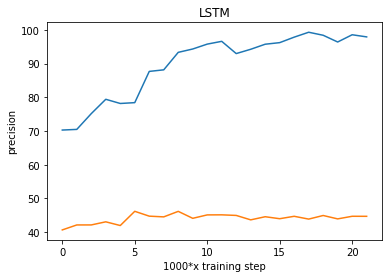

precision of the model on thevalidationdata: 45.970027923583984%
tensor([1.0000, 0.9999, 0.9991, 0.9995, 0.9942, 0.8251, 1.0000, 0.6557, 0.7006,
        0.6438, 1.0000, 0.9798, 1.0000, 0.8620, 0.9997, 0.9958, 0.9987, 0.9900,
        0.9765, 0.7178, 0.9847, 0.7340, 0.9876, 0.9996, 0.9933, 0.8743, 1.0000,
        0.7395, 1.0000, 0.9387, 0.9974, 0.9967, 0.9992, 0.8854, 0.9998, 0.9997,
        0.6576, 0.9999, 1.0000, 0.9980, 1.0000, 0.9927, 0.9305, 0.6905, 0.9974,
        0.9978, 0.9988, 0.7601, 0.9990, 0.9987, 0.9884, 0.9982, 0.9962, 0.8843,
        0.9854, 0.9165, 0.9999, 0.9851, 0.9999, 1.0000, 0.9941, 0.9522, 0.9572,
        0.9487, 0.9823, 0.8383, 0.6852, 0.9954, 0.9995, 0.9994, 0.9951, 0.9480,
        1.0000, 0.9821, 0.9310, 0.9999, 1.0000, 0.9983, 0.9999, 0.9988, 0.9607,
        0.9961, 0.5575, 0.8050, 0.9891, 0.9998, 0.9975, 0.9999, 0.7626, 0.7254,
        0.9989, 0.9895, 1.0000, 1.0000, 0.9677, 0.9999, 0.9985, 0.9682, 0.9992,
        0.7478], device='cuda:1')
current i is 42
Filte

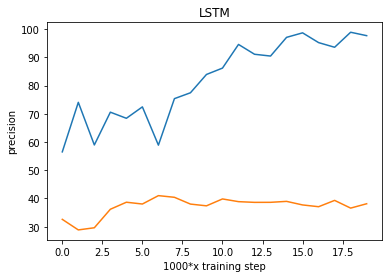

precision of the model on thevalidationdata: 38.13924789428711%
tensor([0.9993, 0.9953, 0.6057, 0.6174, 0.6566, 0.7033, 0.6448, 0.9947, 0.7963,
        0.9741, 0.7732, 0.9681, 0.9916, 0.6690, 0.5936, 0.9538, 0.9849, 0.9892,
        0.9999, 0.9985, 0.9554, 0.9500, 0.5663, 0.8045, 0.9691, 0.6770, 0.9091,
        0.7092, 0.5070, 0.5700, 0.9993, 0.6455, 0.5437, 0.5243, 0.5319, 0.7047,
        0.9967, 0.9936, 0.7893, 0.6000, 0.5878, 0.9396, 0.5238, 0.5871, 0.7200,
        0.5467, 0.6121, 0.6544, 0.9964, 0.9990, 0.9873, 0.9290, 0.5747, 0.6863,
        0.9669, 0.9967, 0.8155, 0.8163, 0.6947, 0.7055, 0.9371, 0.8510, 0.8862,
        0.5766, 0.6854, 0.9975, 0.9999, 0.6976, 0.9786, 0.9879, 0.9946, 0.9956,
        0.6484, 0.5677, 0.6475, 0.7059, 0.8850, 0.9948, 0.6412, 0.5941, 0.6145,
        0.5848, 0.6575, 0.6470, 0.9999, 0.9499, 0.5857, 0.9796, 0.9255, 0.9629,
        0.6239, 0.5748, 0.6753, 0.5529, 0.9972, 0.9426, 0.9380, 0.5171, 0.6717,
        0.8566], device='cuda:1')
current i is 43
Filter

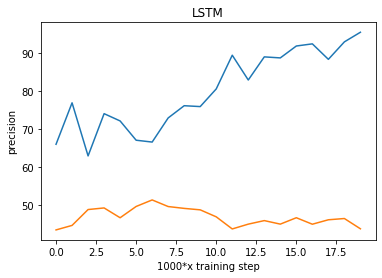

precision of the model on thevalidationdata: 46.398841857910156%
tensor([0.9180, 0.9318, 0.8593, 0.9999, 0.9991, 0.9079, 0.9693, 0.6644, 0.9439,
        0.8658, 0.9418, 0.9996, 0.9995, 0.9937, 0.9996, 0.9657, 0.8241, 0.5852,
        0.9898, 0.6654, 0.9944, 0.9557, 0.8117, 0.9228, 0.9972, 0.9686, 0.9727,
        0.9911, 0.5367, 0.6926, 0.9991, 0.9422, 0.9965, 0.8955, 0.9871, 0.9769,
        0.7063, 1.0000, 0.9855, 0.9999, 0.8034, 0.9990, 0.9958, 0.9909, 0.9978,
        0.5060, 0.9909, 0.5173, 0.9942, 0.9915, 0.9993, 0.9999, 0.9900, 0.9809,
        0.9954, 0.9359, 0.9688, 0.5003, 0.7564, 0.9518, 0.9994, 0.9822, 0.8596,
        0.7019, 0.8103, 0.9639, 0.9868, 0.9457, 0.9873, 0.9980, 0.8945, 0.5134,
        0.9995, 0.9891, 0.9973, 0.9040, 0.9995, 0.9979, 0.9844, 0.9979, 0.9980,
        0.9861, 0.9997, 0.9998, 0.9887, 0.7395, 0.9559, 0.9390, 0.9894, 0.9154,
        0.9967, 0.9974, 0.9950, 0.6224, 0.7140, 0.9628, 0.9595, 0.9550, 0.8405,
        0.8897], device='cuda:1')
current i is 44
Filte

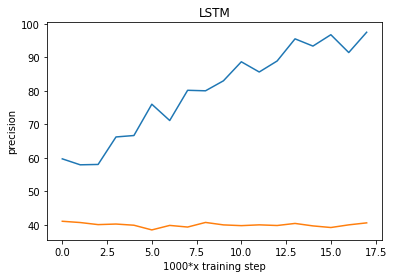

precision of the model on thevalidationdata: 39.5745964050293%
tensor([0.9756, 0.9380, 0.8547, 0.9806, 0.9336, 0.9417, 0.7308, 0.9147, 0.9925,
        0.9660, 0.9807, 0.9985, 0.7949, 0.9981, 0.9991, 0.8369, 0.5710, 0.7351,
        0.9247, 0.9875, 0.9994, 0.8689, 0.9986, 0.9228, 0.9989, 0.8220, 0.9753,
        0.9900, 0.9451, 0.5654, 0.9407, 0.9988, 1.0000, 0.5703, 0.9945, 0.9963,
        0.9919, 1.0000, 0.8806, 0.8506, 1.0000, 0.8894, 0.8161, 0.9998, 0.9996,
        0.9527, 0.9710, 0.9252, 0.6400, 0.7281, 0.9994, 0.9990, 1.0000, 0.8371,
        0.9726, 0.9989, 0.9995, 0.9413, 0.9937, 0.9931, 0.8840, 0.6941, 0.9863,
        0.5413, 0.7285, 0.6657, 0.8555, 1.0000, 0.9708, 0.9610, 0.9971, 0.9998,
        0.9753, 0.8024, 0.9674, 0.9997, 0.8572, 0.9980, 0.7557, 0.9999, 1.0000,
        0.8757, 0.9825, 0.9512, 0.9996, 0.9961, 0.9654, 0.9994, 0.9995, 0.9939,
        0.9986, 0.8028, 0.5855, 0.9987, 0.9565, 0.9999, 1.0000, 0.5311, 0.9763,
        0.9982], device='cuda:1')
current i is 45
Filter 

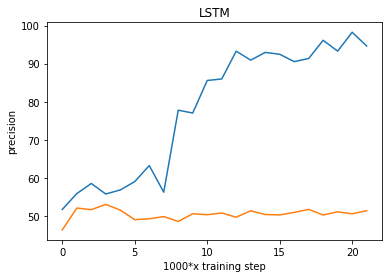

precision of the model on thevalidationdata: 50.53647994995117%
tensor([0.9437, 0.8945, 0.7067, 0.9913, 0.8347, 0.9565, 0.9943, 0.9172, 0.6292,
        0.9604, 0.7472, 0.8674, 0.9890, 0.9980, 0.8165, 0.9951, 0.9974, 0.7952,
        0.9916, 0.5905, 0.9752, 0.6381, 0.5262, 0.6160, 0.9978, 0.9937, 0.9456,
        0.9713, 0.9622, 0.9968, 0.9137, 0.9986, 0.9994, 0.9998, 0.9437, 0.7829,
        0.8944, 0.7403, 0.7033, 0.7547, 0.9886, 0.7693, 0.8756, 1.0000, 0.9519,
        0.7370, 1.0000, 1.0000, 0.9888, 1.0000, 0.9999, 0.9805, 0.9020, 0.9988,
        0.9807, 0.9888, 0.6143, 1.0000, 0.9991, 0.9951, 0.5681, 0.9874, 0.8448,
        0.8643, 0.9886, 0.6346, 0.9975, 0.5501, 0.9998, 0.8626, 0.8940, 0.9580,
        0.9926, 0.9986, 0.8794, 0.8418, 0.6271, 0.8339, 0.9531, 0.9851, 0.8922,
        0.8472, 0.7899, 0.6840, 0.9998, 0.8861, 0.9965, 0.9973, 0.9953, 0.9727,
        0.9994, 0.9198, 0.9992, 0.8111, 0.7480, 0.5434, 0.8437, 0.9711, 0.8441,
        0.9999], device='cuda:1')
current i is 46
Filter

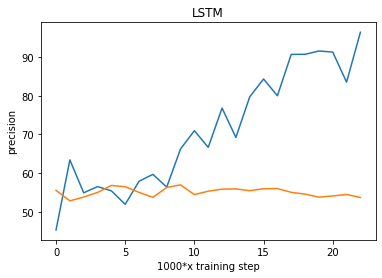

precision of the model on thevalidationdata: 55.5517578125%
tensor([0.9869, 0.9996, 0.9985, 0.9938, 0.9157, 0.9941, 0.8044, 0.8771, 0.8873,
        0.9387, 0.6976, 0.5796, 0.5828, 0.9966, 0.9615, 0.8049, 0.9997, 0.9230,
        0.8836, 0.9174, 0.7533, 0.9912, 0.9999, 1.0000, 0.6253, 0.8770, 0.9242,
        0.9283, 0.8228, 0.9902, 0.7681, 0.6107, 0.9658, 0.7842, 0.9993, 0.9973,
        0.9294, 0.9970, 0.8260, 0.9890, 0.9976, 0.5225, 0.7649, 0.9999, 0.7522,
        0.9820, 0.9775, 0.7277, 0.5252, 0.9010, 0.6295, 0.8919, 0.6706, 0.8654,
        0.9990, 0.9289, 0.9893, 0.8577, 0.6833, 0.9792, 1.0000, 0.9414, 0.6901,
        0.9718, 0.6939, 0.9876, 0.9723, 0.8171, 0.5810, 0.9940, 0.9999, 0.9999,
        0.9969, 0.9977, 0.7827, 0.9610, 0.9950, 0.9293, 0.6568, 0.9997, 0.9998,
        0.9910, 0.9899, 0.7295, 0.8894, 0.9273, 0.9718, 0.8328, 0.9862, 0.9968,
        0.9998, 0.9819, 0.9761, 0.9998, 0.7382, 0.7637, 0.9979, 0.9965, 0.7419,
        0.9792], device='cuda:1')
current i is 47
Filter lar

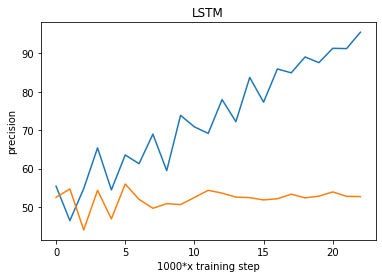

precision of the model on thevalidationdata: 52.167415618896484%
tensor([0.9696, 0.9995, 0.8527, 0.9341, 0.9259, 0.9989, 0.9856, 0.9988, 0.9615,
        0.8046, 0.9804, 0.9994, 0.9990, 0.9892, 0.8551, 0.9996, 0.9723, 0.6564,
        0.9727, 0.6806, 1.0000, 0.7646, 0.9456, 0.6804, 0.5977, 0.8534, 0.5719,
        0.9960, 0.9998, 0.9997, 0.6847, 0.9995, 0.9995, 0.6083, 0.9995, 0.9090,
        0.6424, 0.9979, 0.8752, 0.9954, 0.9999, 0.6739, 0.9999, 0.9738, 0.9039,
        0.9925, 0.9997, 0.9299, 0.5751, 0.8754, 0.6500, 0.9996, 0.5356, 0.6652,
        0.6573, 0.9972, 0.9897, 0.9665, 0.9986, 0.9938, 0.8954, 0.5546, 0.9989,
        0.9995, 0.9686, 0.5023, 0.5912, 0.6967, 0.7697, 0.9981, 0.8645, 0.9969,
        0.9502, 0.6152, 0.7149, 0.9999, 1.0000, 0.5770, 0.5894, 0.7122, 0.9718,
        0.9977, 0.9889, 0.7212, 0.7836, 0.5721, 0.8894, 0.6125, 0.9941, 0.9572,
        0.9996, 0.9532, 0.9560, 0.9993, 0.9999, 0.9286, 0.9983, 0.9997, 0.7058,
        0.5534], device='cuda:1')
current i is 48
Filte

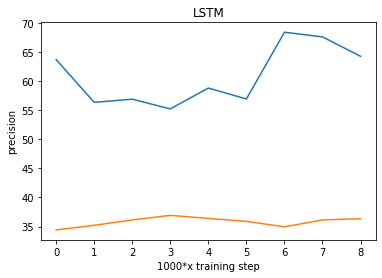

precision of the model on thevalidationdata: 36.256248474121094%
tensor([0.9654, 0.5446, 0.5990, 0.9920, 0.7888, 0.6366, 0.9952, 0.9284, 0.6680,
        0.5488, 0.6406, 0.7947, 0.5950, 0.9973, 0.6545, 0.6353, 0.6810, 0.5087,
        0.5946, 0.9728, 0.6598, 0.6944, 0.5366, 0.8788, 0.9978, 0.6038, 0.6450,
        0.6190, 0.6787, 0.9947, 0.7264, 0.9984, 0.8151, 0.9468, 0.6764, 0.6398,
        0.5668, 0.6711, 0.7608, 0.6332, 0.7244, 0.5279, 0.5783, 0.9487, 0.6041,
        0.9700, 0.9933, 0.7995, 0.6768, 0.7650, 0.7850, 0.7152, 0.6421, 0.8934,
        0.5605, 0.5996, 0.5228, 0.8026, 0.6413, 0.6199, 0.9919, 0.6636, 0.6561,
        0.6433, 0.9114, 0.9437, 0.6202, 0.6876, 0.6077, 0.5275, 0.5803, 0.5320,
        0.5156, 0.6496, 0.6459, 0.6941, 0.9679, 0.6533, 0.5739, 0.7608, 0.5003,
        0.7451, 0.9439, 0.5354, 0.9933, 0.5531, 0.6775, 0.5040, 0.7602, 0.7458,
        0.5388, 0.9288, 0.8630, 0.5103, 0.8227, 0.9525, 0.6520, 0.5469, 0.6242,
        0.8905], device='cuda:1')
current i is 49
Filte

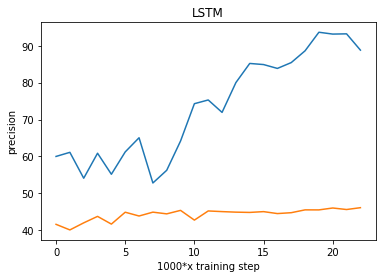

precision of the model on thevalidationdata: 45.87061309814453%
tensor([0.9847, 0.9985, 0.7980, 0.9989, 0.5475, 0.9165, 0.9973, 0.9995, 0.9886,
        0.9841, 0.9995, 0.9799, 0.7127, 0.5299, 0.8118, 0.6582, 0.7055, 0.9069,
        0.9903, 0.8601, 0.9917, 0.9980, 0.5372, 0.9953, 0.9960, 0.9887, 0.9602,
        0.6075, 0.6874, 0.9734, 0.8085, 0.6925, 0.9989, 0.7362, 0.9924, 0.9992,
        0.9972, 0.9989, 0.9980, 0.9992, 0.5532, 0.9888, 0.6028, 0.9999, 0.6078,
        0.9510, 0.6445, 0.9971, 0.8054, 0.9975, 0.5159, 0.9325, 0.9929, 0.8838,
        0.9909, 0.8316, 0.7425, 0.9964, 0.6480, 0.8204, 0.9368, 0.9999, 0.8275,
        0.9916, 0.9822, 0.6578, 0.9689, 0.9967, 0.9990, 0.8391, 0.9957, 0.6876,
        0.6682, 0.6292, 0.5703, 0.9994, 0.6030, 0.9989, 0.9878, 0.7779, 0.9989,
        0.5623, 0.7989, 0.6537, 0.8006, 0.9941, 0.8683, 0.9965, 0.9805, 0.7577,
        0.9976, 0.9727, 0.9999, 0.9968, 0.7722, 0.8112, 0.9947, 0.9537, 0.9968,
        0.6906], device='cuda:1')
current i is 50
Filter

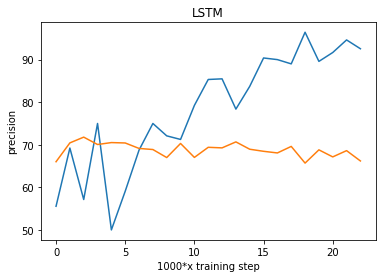

precision of the model on thevalidationdata: 67.21675872802734%
tensor([0.9553, 0.6337, 0.9735, 0.9986, 0.5116, 0.9805, 0.5192, 0.7271, 0.9977,
        0.5590, 0.5226, 0.7100, 0.9822, 0.9854, 0.9999, 0.8617, 0.6481, 0.9933,
        0.8771, 0.8245, 0.8498, 0.9777, 0.9945, 0.9911, 0.7126, 0.7676, 0.5134,
        0.7871, 0.7831, 0.9996, 0.7127, 0.7410, 0.9283, 0.6912, 0.9525, 0.9999,
        0.9998, 0.9993, 0.9993, 0.5025, 0.6754, 0.9401, 1.0000, 0.8628, 0.5868,
        0.8983, 0.9056, 0.8741, 0.9404, 0.9973, 0.9630, 0.6976, 0.5324, 0.7914,
        0.9854, 0.9906, 0.7624, 0.7649, 0.9465, 0.9969, 0.9190, 0.9988, 0.5688,
        0.6213, 0.6847, 0.9284, 0.5365, 0.5393, 0.9991, 0.9985, 0.6679, 0.9928,
        0.9677, 0.9579, 0.9920, 0.7039, 0.9915, 0.9781, 0.9770, 0.9957, 0.7840,
        0.7138, 0.8365, 0.9287, 0.9986, 0.9994, 0.9687, 0.6607, 0.5201, 0.6686,
        0.9985, 0.9459, 0.9067, 0.9977, 0.9725, 0.6314, 0.6640, 0.5442, 0.7720,
        0.5548], device='cuda:1')
current i is 51
Filter

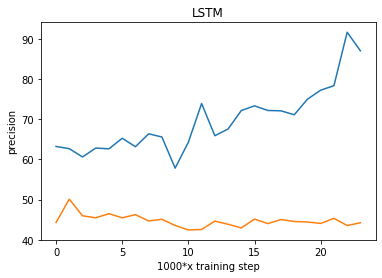

precision of the model on thevalidationdata: 44.13637924194336%
tensor([0.9925, 0.5760, 0.9895, 0.5409, 0.9727, 0.8901, 0.9986, 0.8700, 0.9690,
        0.6843, 0.9966, 0.9893, 0.5367, 0.9757, 0.9396, 0.9914, 0.9954, 0.8772,
        0.9153, 0.6346, 0.9906, 0.9291, 0.9074, 0.9156, 0.8883, 0.9934, 0.5919,
        0.9017, 0.7448, 0.9656, 0.8945, 0.9736, 0.8902, 0.9818, 0.7055, 0.9762,
        0.8709, 0.5104, 0.6057, 0.9898, 0.5012, 0.8002, 0.5820, 0.7075, 0.8481,
        0.9656, 0.9914, 0.9640, 0.9886, 0.5492, 0.9670, 0.5599, 0.9110, 0.8288,
        0.9626, 0.9891, 0.5549, 0.5677, 0.9998, 0.9784, 0.5945, 0.7408, 0.8345,
        0.9359, 0.9018, 0.6646, 0.9670, 0.8713, 0.8827, 0.8686, 0.9592, 0.6790,
        0.7535, 0.6193, 0.7234, 0.7916, 0.9970, 0.8856, 0.9988, 0.6098, 0.7468,
        0.7757, 0.6959, 0.9994, 0.9831, 0.7915, 0.9978, 0.9397, 0.9816, 0.9933,
        0.9748, 0.9999, 0.7715, 0.5624, 0.9249, 0.7595, 0.9256, 0.6715, 0.9771,
        0.7440], device='cuda:1')
current i is 52
Filter

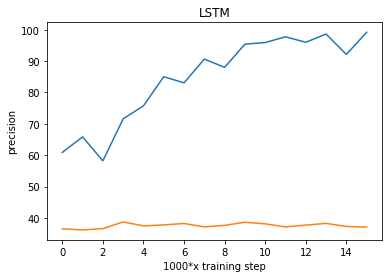

precision of the model on thevalidationdata: 36.812747955322266%
tensor([0.9804, 0.7270, 0.7357, 0.9904, 0.9737, 0.7308, 0.9997, 0.9997, 1.0000,
        0.9416, 0.9951, 0.9970, 0.7363, 0.9942, 0.7806, 0.9067, 0.7716, 0.5784,
        0.9998, 1.0000, 0.9909, 0.6405, 0.9016, 0.9913, 0.8221, 0.8723, 0.9999,
        0.7266, 0.7143, 0.8347, 0.7346, 0.9994, 0.9974, 0.5905, 0.8149, 0.9161,
        0.7795, 0.9349, 0.9903, 0.9997, 0.9923, 0.7253, 0.9945, 0.9955, 0.9883,
        0.7937, 0.9988, 0.9980, 0.9994, 0.9536, 0.9477, 0.9905, 0.9861, 0.9995,
        0.9382, 0.9553, 0.9819, 1.0000, 0.9278, 0.8024, 0.9514, 0.8071, 0.6766,
        0.9962, 0.9763, 0.9995, 0.9847, 1.0000, 0.9688, 0.9996, 0.9107, 0.9860,
        0.6083, 0.8903, 0.9798, 0.9987, 0.8158, 0.9956, 0.9996, 0.8866, 0.9894,
        0.9857, 0.9995, 0.8413, 1.0000, 0.9868, 0.9959, 0.9993, 0.9119, 0.9446,
        0.9196, 0.9253, 0.8577, 0.9879, 1.0000, 0.9972, 0.9909, 0.5161, 0.5286,
        0.6488], device='cuda:1')
current i is 54
Filte

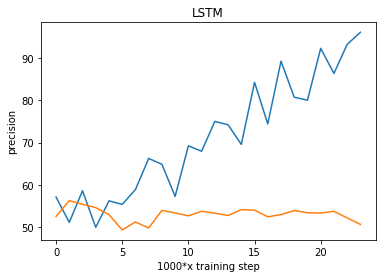

precision of the model on thevalidationdata: 53.066036224365234%
tensor([0.9934, 0.9998, 0.7492, 0.9984, 0.9843, 0.6391, 0.9981, 0.9134, 0.6643,
        0.8769, 0.8369, 0.7621, 0.7974, 0.9983, 0.9764, 0.6080, 0.7201, 0.5161,
        0.7158, 0.8380, 0.8842, 0.9027, 0.5152, 0.9734, 0.5701, 0.6224, 0.5789,
        0.5557, 0.8760, 0.9742, 0.7519, 0.9758, 0.5401, 0.7939, 0.9789, 0.9393,
        0.5908, 0.9998, 0.9565, 0.6763, 0.6766, 0.9999, 0.9991, 0.8840, 0.6661,
        0.6346, 0.9973, 0.7571, 0.6725, 0.9956, 0.8011, 0.6420, 0.7541, 0.8587,
        0.9349, 0.9655, 0.9346, 1.0000, 0.8038, 0.9683, 0.7230, 0.9717, 0.9921,
        0.9519, 0.9491, 0.5906, 0.8334, 1.0000, 0.9840, 0.9950, 0.7831, 0.8694,
        0.9990, 0.6331, 0.5050, 0.9278, 0.5393, 0.5009, 0.9948, 0.6253, 0.9117,
        0.5512, 0.7870, 0.9304, 0.5103, 0.9646, 0.9929, 0.9919, 0.5694, 0.5826,
        0.9831, 0.9659, 0.9995, 0.9267, 0.9958, 0.7531, 0.7158, 0.7671, 0.8681,
        0.9899], device='cuda:1')
current i is 55
Filte

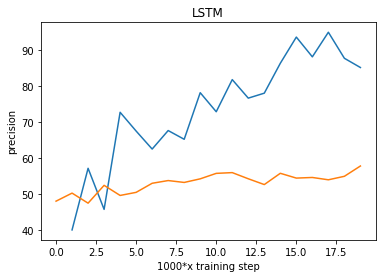

precision of the model on thevalidationdata: 57.35293960571289%
tensor([0.9813, 0.9973, 0.5463, 0.5261, 0.8060, 0.5161, 0.9959, 1.0000, 0.7532,
        0.9019, 0.7416, 0.7919, 0.9675, 0.8469, 0.7572, 0.9995, 0.9334, 0.7312,
        0.5718, 0.9932, 0.9995, 0.9975, 0.9913, 0.8365, 0.7282, 0.5636, 0.9848,
        0.6869, 0.9978, 0.9992, 0.9999, 0.9644, 0.9998, 0.8081, 0.8705, 0.9342,
        0.8084, 0.9415, 0.9147, 0.7510, 0.7744, 0.6381, 0.9735, 0.9666, 0.9594,
        0.9985, 0.7764, 0.9964, 0.7219, 0.5918, 0.9382, 0.8127, 0.5078, 0.5347,
        0.9969, 0.9557, 0.9675, 0.6454, 0.6824, 0.7576, 0.9852, 0.9885, 0.6970,
        0.8028, 0.9641, 0.7106, 0.9058, 0.9744, 0.8303, 0.9077, 0.6881, 0.8435,
        0.9935, 0.5528, 0.7748, 0.7521, 0.6775, 0.6586, 0.6706, 0.9001, 0.9686,
        0.6153, 0.9277, 0.8689, 0.9909, 0.9242, 0.9771, 0.9946, 0.9282, 0.9995,
        0.8828, 0.8401, 0.9972, 0.9380, 0.7581, 0.5077, 0.6672, 0.9999, 0.9999,
        0.5209], device='cuda:1')
current i is 56
Filter

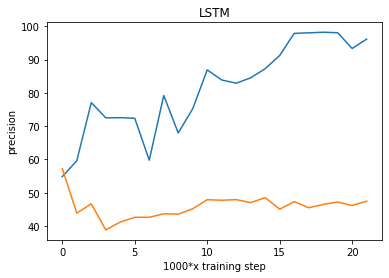

precision of the model on thevalidationdata: 48.12382888793945%
tensor([0.8751, 0.9989, 0.7082, 0.8734, 0.7845, 0.9974, 0.9997, 1.0000, 0.9949,
        0.7894, 0.8488, 0.9593, 0.9998, 0.9897, 0.9459, 0.9947, 0.9887, 0.9810,
        1.0000, 0.9732, 0.8433, 0.9163, 0.5962, 0.5403, 0.9642, 1.0000, 0.9671,
        0.9979, 0.9943, 1.0000, 0.5554, 0.7191, 0.6774, 0.8608, 0.9872, 0.9562,
        0.8640, 0.5923, 0.9954, 0.8502, 0.6686, 0.9979, 0.9989, 0.7860, 0.9997,
        0.9996, 0.7914, 0.8064, 1.0000, 0.8646, 0.9998, 0.9489, 0.9984, 0.9997,
        0.9418, 0.9999, 0.9553, 0.9987, 0.9986, 0.9999, 0.9985, 0.9993, 0.8636,
        0.9995, 0.9950, 0.9977, 0.7657, 0.9279, 0.9999, 0.9984, 0.9997, 0.9441,
        0.9916, 0.9053, 0.9951, 0.9924, 0.9332, 0.9999, 0.9912, 0.9962, 0.9900,
        0.7829, 1.0000, 0.9206, 0.8299, 1.0000, 0.9996, 0.9988, 0.6367, 1.0000,
        0.9999, 0.8511, 0.6244, 0.8401, 0.9928, 0.9995, 0.9938, 0.9998, 0.9964,
        0.9968], device='cuda:1')
current i is 57
Filter

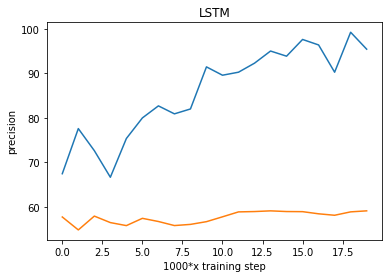

precision of the model on thevalidationdata: 58.56597137451172%
tensor([0.9921, 0.9569, 0.9689, 0.8944, 1.0000, 0.8843, 0.9917, 0.9832, 0.9968,
        0.9968, 0.9881, 1.0000, 0.5809, 0.9957, 0.9991, 0.9997, 0.9963, 0.9992,
        0.9979, 0.9933, 0.8057, 0.9086, 0.9997, 0.9998, 0.9259, 0.9999, 0.9981,
        0.6000, 0.7901, 0.9802, 0.9999, 0.9977, 0.9802, 0.9761, 0.9996, 0.9247,
        0.9999, 0.9991, 0.9988, 0.9999, 0.9987, 0.8254, 0.9984, 1.0000, 0.9997,
        1.0000, 0.9608, 0.9996, 0.9831, 0.9973, 0.9990, 0.9943, 0.9992, 0.9796,
        0.8559, 0.9979, 0.8803, 0.9786, 0.8032, 0.9800, 0.9118, 0.9981, 0.7451,
        0.9952, 0.9999, 0.9588, 0.5431, 0.5338, 1.0000, 0.9999, 0.9961, 0.9987,
        0.9920, 0.9954, 0.9986, 0.9929, 0.9974, 0.9735, 0.9805, 0.8651, 0.9267,
        0.9998, 0.7646, 0.9830, 0.7554, 0.9989, 0.5383, 0.9839, 0.8796, 0.9990,
        0.6497, 0.9487, 0.9982, 0.9992, 0.9532, 0.9620, 0.9965, 0.7743, 0.7060,
        0.7922], device='cuda:1')
current i is 58
Filter

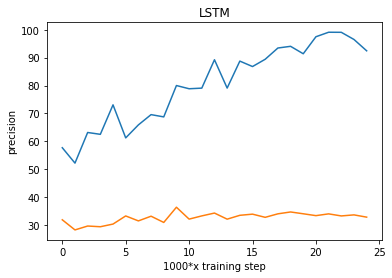

precision of the model on thevalidationdata: 33.56828308105469%
tensor([0.7969, 0.6655, 0.9475, 0.9816, 0.9889, 0.9507, 0.6588, 0.9974, 0.9995,
        0.5187, 0.9544, 0.9954, 0.9960, 0.9986, 0.9976, 0.9083, 0.9998, 0.9982,
        0.9992, 0.7805, 0.9262, 0.9806, 0.9948, 0.9996, 0.9098, 0.9999, 0.9981,
        0.9939, 0.9281, 0.5244, 0.9971, 0.9987, 0.9805, 0.9896, 0.9000, 0.9991,
        0.8239, 0.9994, 0.7452, 0.9777, 0.9768, 0.9662, 0.9992, 0.9998, 0.9886,
        0.5955, 0.5818, 0.8932, 0.8403, 0.9314, 0.9523, 0.9621, 0.9962, 0.9874,
        0.9202, 0.9737, 0.9197, 0.9948, 0.9371, 0.9363, 0.9514, 0.6870, 0.9937,
        0.9718, 0.9936, 0.9121, 0.8094, 0.7411, 0.6790, 0.6036, 0.7067, 0.9966,
        0.7482, 0.9957, 0.9828, 0.9997, 0.9995, 0.9989, 0.7897, 0.8504, 0.9625,
        0.9776, 0.9644, 0.9703, 0.9997, 0.9918, 0.9988, 0.6757, 0.6877, 0.9720,
        0.9951, 0.7964, 0.9999, 0.9967, 0.9841, 0.6710, 0.9997, 0.9909, 0.7892,
        0.8714], device='cuda:1')
current i is 59
Filter

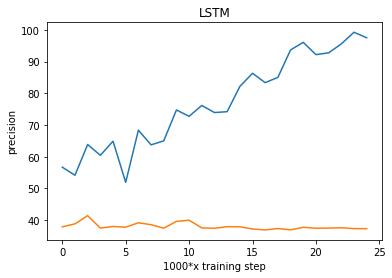

precision of the model on thevalidationdata: 37.26034164428711%
tensor([0.8670, 0.8923, 0.9661, 0.9702, 0.9908, 0.5853, 0.9958, 0.9082, 0.9908,
        0.9858, 0.6664, 0.9989, 0.9490, 0.9925, 0.9994, 0.5988, 0.5099, 0.9989,
        0.9909, 0.9612, 0.9919, 0.8826, 0.6216, 0.7108, 0.9997, 0.9293, 0.9276,
        0.8849, 0.7113, 0.9987, 0.7853, 0.9074, 0.9549, 0.5965, 0.9293, 0.9533,
        0.9985, 0.8601, 0.9997, 0.9959, 0.8798, 0.8640, 0.8430, 0.9786, 0.9906,
        0.5223, 0.9761, 0.9479, 0.8162, 0.7579, 0.9911, 0.8562, 0.9635, 0.9982,
        0.9389, 0.9974, 0.6560, 0.9999, 0.5948, 0.8011, 0.9450, 0.7296, 0.8289,
        0.9385, 0.9195, 0.9982, 0.9957, 0.9798, 0.5618, 0.9336, 0.9988, 0.8257,
        0.8867, 0.8749, 0.6581, 0.9571, 0.9919, 0.7434, 0.7465, 0.9965, 0.9932,
        0.9917, 0.9802, 0.9980, 1.0000, 0.9977, 0.9787, 0.8954, 0.9987, 0.9993,
        0.9928, 0.8892, 0.9946, 0.6193, 0.9868, 0.9536, 0.6086, 0.9396, 0.9356,
        0.9738], device='cuda:1')
current i is 60
Filter

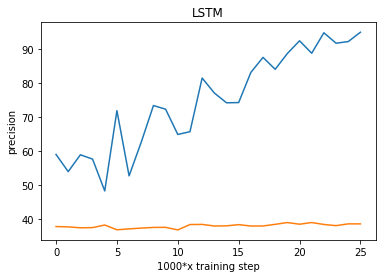

precision of the model on thevalidationdata: 37.45835494995117%
tensor([0.5091, 0.9077, 0.9513, 0.9998, 0.9765, 0.9550, 0.7887, 0.7383, 0.9414,
        0.9461, 0.9950, 0.9990, 0.9979, 0.9518, 0.9443, 0.9743, 0.9924, 0.9931,
        0.7700, 0.5642, 0.5471, 0.9615, 0.9922, 0.9971, 0.8860, 0.9998, 0.6161,
        0.9095, 0.9928, 0.9982, 0.6005, 0.9837, 0.9947, 0.8029, 0.8508, 0.6319,
        0.5661, 0.5504, 0.5752, 0.6957, 0.7279, 0.9573, 0.9990, 0.6862, 0.9824,
        0.7649, 0.6298, 0.5351, 0.8694, 0.8491, 0.9994, 0.5898, 0.6343, 0.9824,
        0.9980, 0.5736, 0.5343, 0.6888, 0.9594, 0.9975, 0.9996, 0.8255, 0.5267,
        0.7642, 1.0000, 0.9936, 0.9747, 0.8838, 0.6273, 0.6855, 0.6320, 0.8001,
        0.9995, 0.5238, 0.9930, 0.9792, 0.9054, 0.9244, 0.6278, 0.9921, 0.9508,
        0.9607, 0.6737, 0.9744, 0.9383, 0.7987, 0.6290, 0.6169, 0.5665, 0.9984,
        0.9975, 0.9715, 0.6594, 0.9224, 0.9934, 0.6849, 0.6023, 0.9227, 0.9979,
        0.8505], device='cuda:1')
current i is 61
Filter

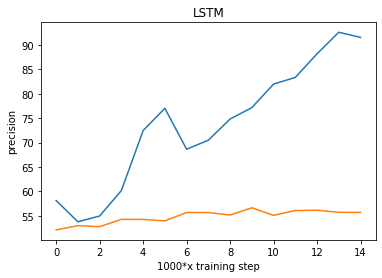

precision of the model on thevalidationdata: 56.400699615478516%
tensor([0.9917, 0.9175, 0.9734, 0.9994, 0.9984, 0.9994, 0.7108, 0.9990, 0.7970,
        0.9855, 0.9850, 0.5466, 0.9809, 0.9930, 0.8942, 0.5415, 0.8033, 0.6652,
        0.9592, 0.9985, 0.9798, 0.8658, 0.5251, 0.9907, 0.9101, 0.5758, 0.6707,
        0.8040, 0.9119, 0.6455, 0.9989, 0.9996, 0.5646, 0.9435, 0.6827, 0.9154,
        0.9825, 0.9315, 0.9769, 0.9494, 0.9859, 0.9836, 0.9873, 0.9946, 0.5519,
        0.5236, 0.5489, 0.5602, 0.9431, 0.8533, 0.9999, 0.7577, 0.9944, 0.9994,
        0.9047, 0.6488, 0.9999, 0.9094, 0.7553, 0.8911, 0.7616, 0.6256, 0.9865,
        0.9993, 0.8999, 0.7970, 0.9776, 0.8217, 0.7322, 0.5759, 0.6966, 0.9006,
        0.6107, 0.5752, 0.7906, 0.9994, 0.9915, 0.7905, 0.7104, 0.7269, 0.9997,
        0.9916, 0.9264, 0.8683, 0.8727, 0.9772, 0.6991, 0.7555, 0.5393, 0.9046,
        0.9335, 0.9045, 0.8339, 0.9983, 0.9968, 0.6555, 0.7065, 0.9378, 0.6332,
        0.5840], device='cuda:1')
current i is 62
Filte

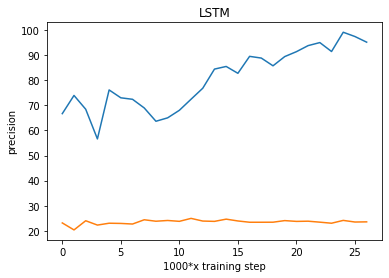

precision of the model on thevalidationdata: 24.637042999267578%
tensor([0.5332, 0.5078, 0.5836, 0.7269, 0.9946, 0.8088, 0.9137, 0.9711, 0.8920,
        0.5428, 0.9074, 0.9926, 0.9979, 0.9887, 0.9999, 0.9993, 0.8049, 0.8992,
        0.9989, 0.9895, 0.9999, 0.9766, 1.0000, 0.9310, 0.9996, 0.9282, 0.6092,
        0.9873, 0.9996, 0.9430, 0.6228, 0.9983, 0.5920, 0.9429, 0.9910, 0.9670,
        0.9998, 0.9586, 0.9901, 0.9999, 0.9892, 0.9410, 0.6662, 0.7312, 0.9607,
        0.9763, 0.9933, 0.9333, 0.6583, 0.8348, 0.5453, 0.9901, 0.9974, 0.9322,
        0.9743, 0.8902, 0.9106, 0.9996, 0.5703, 0.9999, 0.9988, 0.9996, 0.8460,
        0.9865, 0.5307, 0.9982, 0.9662, 0.9939, 0.9196, 0.9358, 0.9344, 0.7645,
        0.6530, 0.9997, 0.7370, 0.9520, 0.5854, 0.9866, 0.9986, 0.9972, 0.8331,
        0.6893, 0.7126, 0.6976, 0.5079, 0.7802, 0.9584, 0.5342, 0.9989, 0.8288,
        0.5082, 0.9318, 0.7680, 0.9531, 0.9941, 0.8613, 0.9973, 0.9994, 0.9995,
        0.5509], device='cuda:1')
current i is 63
Filte

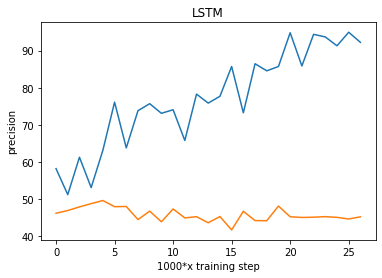

precision of the model on thevalidationdata: 43.564815521240234%
tensor([0.9997, 0.9577, 0.9990, 0.9972, 0.8057, 0.5506, 0.9996, 0.8154, 0.9998,
        0.8063, 0.9267, 1.0000, 0.8389, 0.8971, 0.9671, 0.9484, 0.5476, 1.0000,
        0.9998, 0.9996, 0.9999, 0.9762, 0.8141, 0.9998, 0.9919, 0.9681, 0.9999,
        0.9768, 1.0000, 1.0000, 0.9994, 0.9861, 0.7577, 0.9992, 1.0000, 1.0000,
        0.9954, 0.9988, 0.9994, 0.9997, 0.9963, 1.0000, 0.6746, 0.8806, 0.9957,
        0.5844, 0.9919, 0.9355, 0.9997, 1.0000, 0.9934, 0.9985, 0.9999, 1.0000,
        0.9990, 1.0000, 0.9078, 0.9997, 0.7014, 0.9999, 0.9994, 0.9822, 0.9999,
        0.5022, 0.9910, 0.9616, 0.9962, 0.8168, 0.9838, 0.9312, 0.9995, 0.9644,
        0.9998, 1.0000, 0.9997, 0.9921, 0.9677, 0.9985, 0.9959, 0.9464, 1.0000,
        0.6255, 0.9504, 0.9948, 0.9050, 0.9745, 0.9841, 0.6877, 0.5354, 0.9959,
        0.6858, 0.9987, 0.9999, 0.9994, 0.9999, 0.9989, 0.9350, 0.9567, 0.7812,
        0.9987], device='cuda:1')
current i is 64
Filte

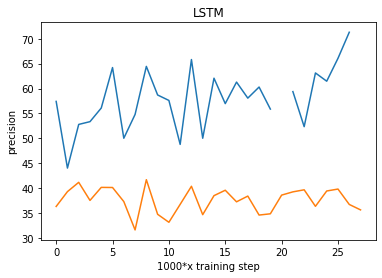

precision of the model on thevalidationdata: 35.59321975708008%
tensor([0.6871, 0.5222, 0.5778, 0.5210, 0.5466, 0.6806, 0.5064, 0.6398, 0.8112,
        0.6242, 0.5431, 0.5289, 0.5738, 0.5201, 0.5219, 0.6155, 0.5434, 0.5471,
        0.6801, 0.5461, 0.5046, 0.6946, 0.5058, 0.7168, 0.5382, 0.6662, 0.5518,
        0.6696, 0.5095, 0.7035, 0.6282, 0.5758, 0.5682, 0.5981, 0.6801, 0.5987,
        0.5828, 0.5656, 0.6929, 0.8012, 0.5468, 0.5698, 0.5195, 0.5086, 0.5190,
        0.5251, 0.5144, 0.6012, 0.6037, 0.5211, 0.6164, 0.7805, 0.6053, 0.5611,
        0.5378, 0.5399, 0.6286, 0.5815, 0.5025, 0.5337, 0.5412, 0.6501, 0.5803,
        0.5506, 0.5876, 0.5464, 0.6794, 0.6898, 0.6614, 0.5020, 0.5390, 0.6100,
        0.5721, 0.5660, 0.9301, 0.5298, 0.5915, 0.5862, 0.7085, 0.5220, 0.6440,
        0.5420, 0.5360, 0.5037, 0.5681, 0.5110, 0.6159, 0.5862, 0.6743, 0.6459,
        0.5325, 0.5721, 0.6480, 0.5427, 0.5137, 0.5017, 0.5881, 0.7406, 0.6232,
        0.5042], device='cuda:1')
current i is 65
Filter

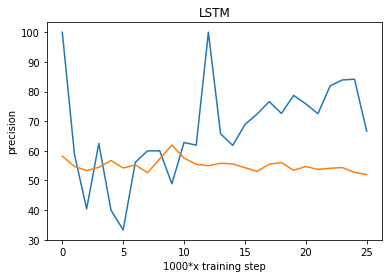

precision of the model on thevalidationdata: 51.976707458496094%
tensor([0.9174, 0.7379, 0.5515, 0.6601, 0.8077, 0.5861, 0.5589, 0.8041, 0.7178,
        0.5365, 0.5495, 0.5462, 0.6600, 0.6594, 0.6783, 0.6015, 0.5394, 0.7255,
        0.6419, 0.6740, 0.5600, 0.5649, 0.5037, 0.5246, 0.8599, 0.5751, 0.6302,
        0.8017, 0.5410, 0.5270, 0.8701, 0.7698, 0.6863, 0.6185, 0.5844, 0.5217,
        0.6592, 0.9001, 0.6496, 0.6258, 0.5626, 0.6914, 0.7062, 0.5064, 0.6180,
        0.6294, 0.5885, 0.7626, 0.9373, 0.9189, 0.8674, 0.5282, 0.6584, 0.5095,
        0.5255, 0.6056, 0.6893, 0.5930, 0.5454, 0.5017, 0.6278, 0.6442, 0.6023,
        0.9243, 0.9754, 0.9183, 0.5310, 0.5483, 0.6643, 0.5542, 0.7182, 0.5055,
        0.7346, 0.9443, 0.6941, 0.9003, 0.5232, 0.6495, 0.5019, 0.9519, 0.6223,
        0.5063, 0.5788, 0.6400, 0.6513, 0.7563, 0.5407, 0.9994, 0.9546, 0.9985,
        0.6975, 0.7843, 0.6429, 0.7752, 0.6762, 0.8617, 0.8272, 0.8009, 0.9961,
        0.9180], device='cuda:1')
current i is 66
Filte

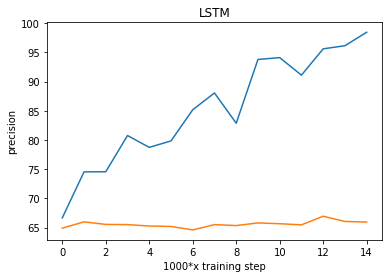

precision of the model on thevalidationdata: 66.32124328613281%
tensor([0.9883, 0.9979, 0.9948, 0.9725, 0.9998, 0.9946, 0.9999, 0.9969, 0.9998,
        0.9348, 0.9962, 0.9943, 1.0000, 1.0000, 1.0000, 0.7946, 0.9460, 0.8875,
        0.9549, 0.9387, 0.9953, 0.9959, 0.6724, 0.9543, 0.8276, 0.9873, 0.9920,
        0.9998, 0.9998, 0.5399, 0.6788, 0.9965, 0.9362, 0.7025, 0.8268, 0.9651,
        0.9998, 0.7991, 0.9983, 0.6103, 0.8815, 0.9965, 0.9736, 0.9996, 0.9967,
        0.9674, 0.9288, 0.8419, 0.9986, 0.8692, 0.8886, 0.9747, 0.9994, 0.9873,
        0.9994, 0.9529, 0.9997, 1.0000, 1.0000, 1.0000, 0.6107, 0.9958, 0.9991,
        0.9246, 0.7287, 0.9696, 0.9947, 0.9941, 1.0000, 0.5008, 0.8668, 0.9572,
        0.5398, 0.5206, 0.9784, 0.9978, 0.9862, 0.9549, 0.9993, 0.9954, 0.8570,
        0.8804, 0.9998, 0.9965, 0.9912, 0.8608, 0.9976, 0.7210, 0.9998, 0.9925,
        0.7392, 0.9999, 0.9234, 0.9991, 0.9977, 0.9996, 0.9280, 0.9983, 1.0000,
        0.5674], device='cuda:1')
current i is 67
Filter

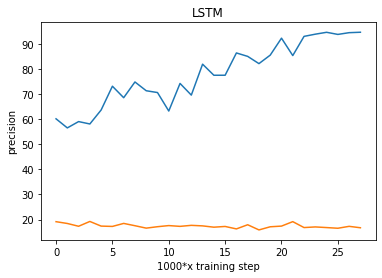

precision of the model on thevalidationdata: 17.236364364624023%
tensor([0.7263, 0.5889, 0.9846, 0.9023, 0.5280, 0.9845, 0.5528, 0.7344, 0.8348,
        0.9794, 0.9995, 0.7054, 0.9958, 0.9947, 0.7387, 0.9917, 0.7437, 0.9730,
        0.9583, 0.9987, 0.7880, 0.9787, 0.5773, 0.9984, 0.9540, 0.5846, 0.9981,
        0.9510, 0.8255, 0.5830, 0.9245, 0.7229, 0.5769, 0.7661, 0.7749, 0.6311,
        0.9996, 0.5199, 0.7949, 0.9994, 0.9957, 0.9987, 0.7233, 0.7042, 0.9403,
        0.9908, 0.5390, 0.6770, 0.5056, 0.7300, 0.6059, 0.8898, 0.9991, 0.9633,
        0.9534, 0.8192, 0.9967, 0.9369, 0.9333, 0.9990, 0.9577, 0.8002, 0.9709,
        0.9221, 0.9352, 0.9080, 0.9431, 0.8233, 0.5824, 0.9999, 0.8445, 0.9995,
        0.9708, 0.9786, 0.6153, 0.5594, 0.7903, 0.9099, 0.7454, 0.7718, 0.5969,
        0.7985, 0.8926, 0.9971, 0.9846, 0.7902, 0.8442, 0.9471, 0.5262, 0.9838,
        0.6223, 0.9998, 0.9979, 0.9886, 0.9124, 0.9998, 0.9908, 0.9754, 1.0000,
        0.9999], device='cuda:1')
current i is 68
Filte

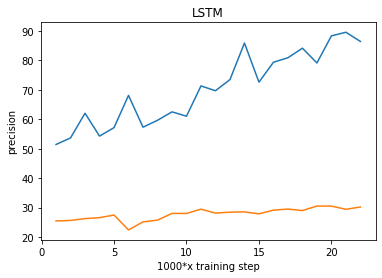

precision of the model on thevalidationdata: 28.9017333984375%
tensor([0.9998, 0.8960, 0.9270, 0.9426, 0.8682, 0.9973, 0.7857, 1.0000, 0.9886,
        0.9212, 0.9491, 0.9966, 0.7616, 0.9185, 0.9275, 0.9943, 0.5496, 0.5337,
        0.7795, 0.9913, 0.8782, 0.9307, 0.9935, 0.7379, 0.9954, 0.9559, 0.9993,
        0.9993, 0.9867, 0.7749, 0.9979, 0.9647, 0.9228, 0.9991, 0.9328, 0.9994,
        0.7770, 0.9866, 0.5227, 0.9992, 0.6432, 0.9354, 0.9036, 0.5716, 0.9886,
        0.7942, 0.9880, 0.6674, 0.9679, 0.8766, 0.9934, 0.9883, 0.9532, 0.5494,
        0.9773, 0.9027, 0.5920, 1.0000, 0.6726, 0.9009, 0.9998, 0.9954, 0.7901,
        0.9995, 0.9970, 0.8074, 0.9639, 0.7045, 0.9339, 0.6439, 0.7832, 0.6999,
        0.9989, 0.9964, 0.8310, 0.9995, 0.9989, 0.8813, 0.6041, 0.7238, 0.8839,
        0.5654, 0.9987, 0.9104, 0.9184, 0.8201, 0.9995, 0.9418, 0.7211, 0.9986,
        0.9899, 0.8284, 0.9981, 0.6814, 0.9237, 0.6873, 0.8709, 0.9462, 0.9897,
        0.9884], device='cuda:1')
current i is 69
Filter 

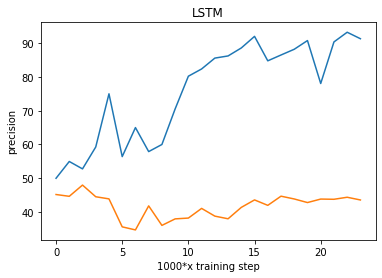

precision of the model on thevalidationdata: 43.57705307006836%
tensor([0.9979, 0.9741, 0.9990, 0.9970, 0.6088, 0.7954, 0.6794, 0.5534, 0.9918,
        0.9777, 0.8694, 0.9996, 0.8486, 0.6576, 0.9470, 0.5593, 0.9359, 0.9572,
        0.9999, 0.6779, 0.9891, 0.9691, 0.9079, 0.9328, 0.8138, 0.9856, 0.9993,
        0.7302, 0.9818, 0.9982, 0.5625, 0.9993, 0.9836, 0.9999, 0.8426, 0.9952,
        0.9245, 0.9962, 0.6898, 0.9834, 0.9889, 0.5345, 0.9706, 0.9805, 0.5110,
        0.9670, 0.9937, 0.9691, 0.9241, 0.9946, 0.9996, 0.5119, 0.9762, 0.9653,
        0.9999, 0.9934, 0.9988, 0.8850, 0.9979, 0.9916, 0.7464, 0.6018, 0.9985,
        0.9977, 0.6499, 0.8276, 0.7281, 0.9995, 0.8972, 0.9789, 0.9999, 0.9920,
        0.9544, 0.9808, 0.6883, 0.9230, 0.6886, 0.6855, 0.6651, 0.9916, 0.9821,
        0.6575, 0.9977, 0.9934, 0.9360, 0.9829, 0.9948, 0.7316, 0.9977, 0.9999,
        0.6541, 0.9872, 0.8426, 0.9243, 0.9958, 0.7591, 0.8573, 0.8904, 0.8029,
        0.9939], device='cuda:1')
current i is 70
Filter

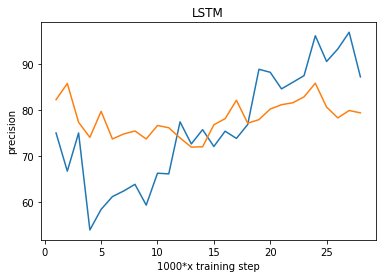

precision of the model on thevalidationdata: 81.67781829833984%
tensor([0.9928, 0.9983, 0.9983, 0.6024, 0.9889, 0.9968, 0.9889, 0.8983, 0.9953,
        0.9909, 0.9952, 0.9307, 0.9994, 1.0000, 0.9980, 0.6610, 0.9999, 0.7012,
        0.9816, 0.9999, 0.9376, 0.9963, 0.9993, 0.8989, 0.9974, 0.9991, 0.9619,
        0.8956, 0.9990, 0.9801, 0.9894, 0.9768, 0.9199, 0.8835, 0.7450, 0.9647,
        1.0000, 0.7784, 0.6287, 0.7552, 0.9120, 0.8251, 0.9999, 0.5881, 0.9805,
        0.9558, 0.7553, 0.8351, 0.9981, 0.9745, 0.9991, 0.7483, 0.8078, 0.9040,
        0.8438, 0.9946, 0.9640, 0.8404, 0.9987, 0.9864, 0.9999, 0.6815, 0.9412,
        0.9370, 0.9977, 0.8399, 0.9999, 0.7051, 0.8183, 0.5495, 0.9998, 0.9927,
        0.6888, 0.9573, 0.9868, 0.9036, 0.9998, 0.8569, 0.9904, 0.5742, 0.9798,
        0.9986, 0.9396, 0.9970, 0.9978, 0.9778, 0.8449, 0.9965, 0.9391, 0.9910,
        0.9642, 0.7063, 0.9960, 0.9859, 0.6311, 0.9827, 0.9994, 0.9745, 0.9904,
        0.8226], device='cuda:1')
current i is 71
Filter

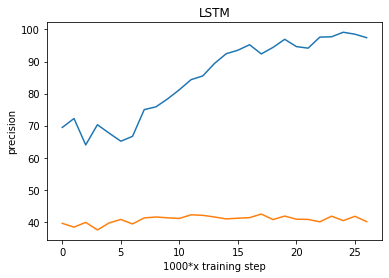

precision of the model on thevalidationdata: 40.97035217285156%
tensor([0.9900, 0.9749, 0.6621, 0.9996, 0.8410, 0.9935, 0.5870, 0.9982, 0.8676,
        0.9833, 0.9998, 0.5541, 0.9950, 0.9962, 0.9723, 0.9814, 0.9635, 0.9956,
        0.9954, 0.9997, 0.9905, 0.9998, 0.9634, 0.9992, 1.0000, 0.8568, 0.9861,
        0.9961, 0.9974, 0.9830, 0.9998, 0.9392, 0.9862, 0.9516, 0.9907, 1.0000,
        0.9987, 0.9226, 0.9776, 0.9995, 0.9999, 0.9993, 0.9961, 0.9999, 0.9990,
        0.7373, 0.9995, 0.6201, 0.9988, 0.9997, 0.9976, 0.9758, 0.9994, 0.9997,
        0.9979, 0.5505, 0.8856, 0.9791, 0.9955, 0.9999, 0.9760, 0.7528, 0.7236,
        0.9659, 0.9284, 0.9803, 0.8282, 0.9989, 0.9486, 0.9587, 0.9833, 0.9979,
        0.9888, 0.9949, 0.9710, 0.9994, 1.0000, 0.6062, 0.9419, 0.9993, 0.9996,
        0.9977, 0.9935, 0.9745, 0.9564, 0.7779, 0.9890, 0.8222, 0.9695, 0.7202,
        0.9998, 0.9999, 0.5931, 0.6978, 1.0000, 1.0000, 0.9994, 0.9998, 0.9999,
        0.7198], device='cuda:1')
current i is 72
Filter

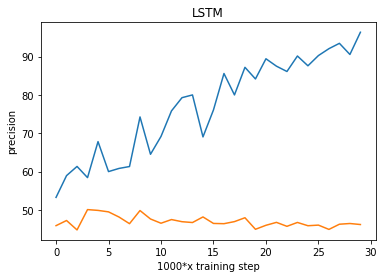

precision of the model on thevalidationdata: 46.61997604370117%
tensor([0.8326, 0.9932, 0.7661, 0.9909, 0.5339, 0.9530, 0.9991, 0.9883, 0.6165,
        0.9501, 0.7875, 0.8235, 0.9644, 0.6322, 0.9820, 0.9811, 0.9664, 0.9787,
        0.8337, 0.5324, 0.5127, 0.8040, 0.7735, 0.7766, 0.9979, 0.9966, 0.9979,
        0.8970, 0.9134, 0.5494, 0.5447, 0.9998, 0.5024, 0.7602, 0.7302, 0.6760,
        0.8570, 0.7270, 0.7234, 0.9516, 0.9495, 0.6840, 0.5155, 0.7757, 0.8295,
        0.9532, 0.8511, 0.8181, 0.8255, 0.8809, 0.6460, 0.7399, 0.8006, 0.9976,
        0.9973, 0.9764, 0.9504, 0.6853, 0.5303, 0.5410, 0.6391, 0.5933, 0.6568,
        0.9888, 0.9992, 0.9866, 0.9943, 0.6954, 0.5893, 0.7615, 0.7123, 0.9062,
        0.7502, 0.9396, 0.8874, 0.9978, 0.9549, 0.8334, 0.9986, 0.9985, 0.9840,
        0.9221, 0.9602, 0.5799, 0.7617, 0.8507, 0.6778, 0.6784, 0.5436, 0.7712,
        0.9690, 0.5182, 0.6099, 0.6650, 0.9849, 0.6499, 0.9991, 0.9814, 0.9115,
        0.9952], device='cuda:1')
current i is 73
Filter

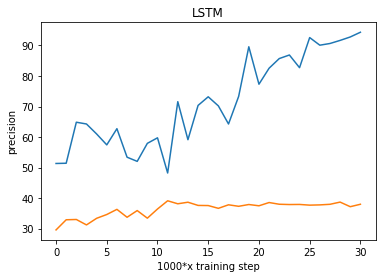

precision of the model on thevalidationdata: 36.92430877685547%
tensor([0.9976, 0.6398, 0.9887, 0.9579, 0.7475, 0.9988, 0.9939, 0.7141, 0.5886,
        0.5245, 0.9997, 0.9997, 0.9877, 0.9271, 0.9906, 0.9840, 0.9921, 0.6041,
        0.9647, 0.9998, 0.7947, 0.9453, 0.8431, 0.9927, 0.8094, 0.9258, 0.9991,
        0.9950, 0.9989, 0.9971, 0.8925, 0.7459, 0.5828, 0.9579, 0.9990, 0.9995,
        0.5512, 0.9991, 0.7187, 0.6946, 0.9998, 0.8576, 0.9998, 0.7242, 0.9989,
        0.9966, 0.5725, 0.6341, 0.7173, 0.8402, 0.7998, 0.8565, 0.8047, 0.8685,
        0.9133, 0.6333, 0.9898, 0.8335, 0.9091, 0.9737, 0.9955, 0.9991, 0.9681,
        0.9954, 0.6742, 0.9056, 0.9965, 0.8375, 0.9095, 0.8219, 0.8379, 0.5939,
        0.9967, 0.9396, 0.7110, 0.6601, 0.9968, 0.8641, 0.6300, 0.8819, 0.9930,
        0.9988, 0.9971, 0.9971, 0.9195, 0.6554, 0.9937, 0.9496, 0.9985, 0.9997,
        0.9729, 0.9295, 0.9989, 0.9290, 0.9921, 0.9097, 0.5502, 0.9321, 0.7745,
        0.9899], device='cuda:1')
current i is 74
Filter

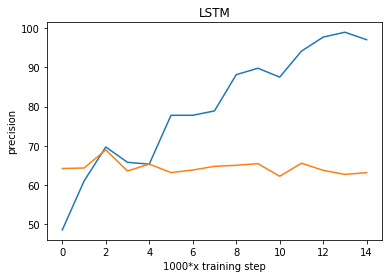

precision of the model on thevalidationdata: 62.84722137451172%
tensor([0.9845, 0.9996, 0.9997, 0.8401, 0.9042, 1.0000, 0.9997, 0.9933, 0.9857,
        0.9867, 1.0000, 1.0000, 0.9957, 0.9699, 0.9984, 0.9966, 0.9646, 0.9988,
        0.9968, 0.9542, 0.9991, 0.9439, 0.8120, 0.9718, 0.9975, 0.9923, 0.9956,
        0.9664, 0.9994, 0.9963, 0.9995, 0.9990, 0.9932, 0.9998, 0.9999, 0.9996,
        0.8110, 0.8671, 0.6268, 0.9996, 0.9216, 0.9485, 0.7017, 0.9759, 0.6434,
        0.8635, 0.9438, 0.9995, 0.9984, 0.9969, 0.7308, 0.7571, 0.9950, 0.9999,
        0.9998, 0.9982, 0.9868, 0.9991, 0.9955, 0.9999, 0.9991, 0.9878, 0.9978,
        0.5466, 0.9990, 0.9852, 0.5741, 0.9979, 0.7081, 0.8994, 0.5624, 0.9938,
        0.9829, 0.9765, 0.9760, 1.0000, 0.6895, 0.9199, 0.8458, 0.9249, 0.9956,
        0.9965, 0.8482, 0.9728, 0.8580, 0.9024, 0.9906, 0.9997, 0.9989, 0.9541,
        0.9957, 0.6592, 1.0000, 1.0000, 0.9983, 0.9939, 0.9996, 0.8200, 0.9986,
        0.9998], device='cuda:1')
current i is 75
Filter

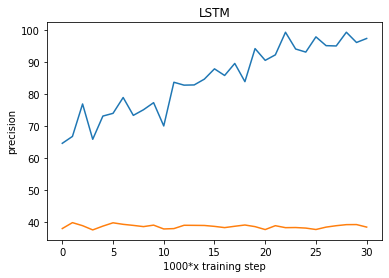

precision of the model on thevalidationdata: 39.35552215576172%
tensor([0.9957, 0.9983, 0.9757, 0.9615, 0.5051, 0.5478, 0.9460, 0.9893, 0.9537,
        0.9990, 0.9995, 0.9480, 0.9982, 0.9987, 0.9941, 0.9800, 0.6738, 0.9983,
        0.9970, 0.9935, 0.9956, 0.5441, 0.9252, 0.9837, 0.9834, 0.6485, 0.9796,
        0.9998, 0.7686, 0.9997, 0.6105, 0.9987, 0.9997, 1.0000, 0.9926, 0.8389,
        0.9991, 0.7507, 0.6304, 0.9940, 0.9991, 0.9028, 0.9200, 0.9997, 0.9998,
        0.9999, 0.9992, 0.8599, 0.9996, 0.9995, 0.9986, 0.8990, 0.9756, 0.8615,
        0.9426, 0.9986, 0.9545, 0.9982, 0.5517, 0.9935, 0.9974, 0.9962, 0.5091,
        0.9995, 0.9995, 0.8492, 0.9984, 0.9967, 0.9992, 0.5976, 0.6532, 0.9996,
        0.5223, 0.9347, 0.9577, 0.9737, 0.9970, 0.6594, 0.9392, 0.9096, 0.9999,
        0.9921, 0.9778, 0.9891, 0.9961, 0.7171, 0.7855, 0.9915, 0.6408, 0.9537,
        0.9741, 0.9950, 0.9998, 0.7952, 0.6812, 1.0000, 0.9975, 0.9980, 0.9289,
        0.9932], device='cuda:1')
current i is 76
Filter

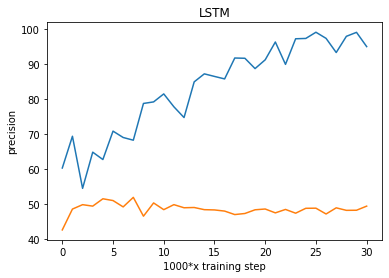

precision of the model on thevalidationdata: 48.19720458984375%
tensor([0.9431, 0.8767, 0.9984, 0.9950, 0.9236, 0.8902, 0.9284, 0.9966, 0.9616,
        0.9797, 0.8172, 0.9993, 0.9864, 0.9817, 0.9997, 1.0000, 0.7048, 0.9993,
        0.5124, 0.9985, 0.6119, 0.8913, 0.8041, 0.8019, 0.6020, 0.6374, 0.6897,
        0.9637, 0.9636, 0.7965, 0.9916, 0.7043, 0.7147, 0.9798, 1.0000, 0.9722,
        0.8193, 0.5913, 0.7124, 0.9566, 0.9999, 0.9986, 0.9564, 0.8447, 0.9567,
        0.9989, 0.9997, 0.8429, 0.9961, 0.9739, 0.9874, 0.9313, 0.8932, 0.9133,
        0.9594, 0.9853, 0.8477, 0.7297, 0.9645, 0.9860, 0.9993, 0.9872, 0.9943,
        0.5064, 0.6024, 0.8140, 0.9808, 0.9950, 0.9513, 0.5519, 0.9885, 1.0000,
        0.5878, 0.9997, 0.9818, 0.6365, 0.9854, 0.9765, 0.9464, 0.9999, 0.9996,
        0.9971, 0.9930, 0.6218, 0.7670, 0.9999, 0.9967, 0.9940, 0.9967, 0.5691,
        0.7959, 0.5691, 0.8741, 0.7701, 0.9615, 0.9468, 0.8465, 0.9979, 0.9994,
        0.6540], device='cuda:1')
current i is 77
Filter

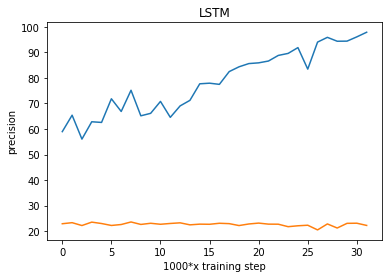

precision of the model on thevalidationdata: 23.04772186279297%
tensor([0.9536, 0.9980, 0.9896, 0.9175, 0.9992, 0.9970, 0.6050, 0.8826, 0.7388,
        0.9998, 0.9718, 0.9988, 0.8219, 0.6689, 0.9372, 0.9808, 0.9995, 0.5428,
        0.9037, 0.5663, 0.6462, 0.9101, 0.9988, 0.9838, 0.9992, 0.9962, 0.8967,
        0.7925, 0.9496, 0.9638, 0.9969, 0.9767, 0.9738, 0.9941, 0.6882, 0.9765,
        0.9043, 0.7784, 0.9147, 0.9993, 0.9239, 0.9781, 0.9947, 0.5433, 0.9969,
        0.9935, 0.8574, 0.9948, 0.9946, 0.8898, 0.9065, 0.9995, 0.9966, 0.5001,
        0.9912, 0.9998, 0.7152, 0.9993, 0.8620, 0.5688, 0.9997, 0.9913, 0.9998,
        0.7688, 0.9903, 0.7961, 0.5786, 0.8778, 0.9902, 0.9116, 0.9977, 0.8921,
        0.8474, 0.9993, 0.9954, 0.9979, 0.9993, 0.5013, 0.9991, 0.9515, 0.8224,
        0.5391, 0.5095, 0.8967, 0.8390, 0.8843, 0.9570, 0.9954, 0.9978, 0.9755,
        0.9991, 0.9840, 0.9835, 0.9338, 0.9990, 0.9988, 0.7927, 0.9321, 0.9670,
        0.9711], device='cuda:1')
current i is 78
Filter

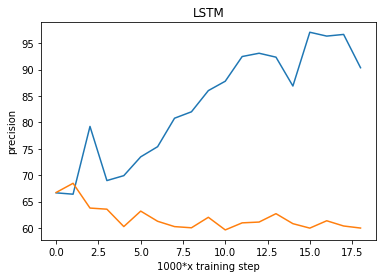

precision of the model on thevalidationdata: 60.0%
tensor([0.9995, 0.6282, 0.9999, 0.9857, 0.7445, 0.9129, 0.9961, 0.9991, 1.0000,
        1.0000, 1.0000, 0.8793, 0.9362, 0.9654, 0.9999, 0.6287, 0.7407, 0.8243,
        0.9999, 0.9762, 0.9894, 0.9788, 0.9992, 0.6509, 0.9504, 0.9351, 0.9210,
        0.8811, 0.9994, 0.9999, 0.8742, 0.9957, 0.9999, 0.9980, 0.9946, 0.9991,
        0.8778, 0.9995, 0.9214, 0.9510, 1.0000, 0.9830, 0.8703, 0.9915, 0.8115,
        0.8294, 0.5623, 0.6594, 0.6882, 0.8777, 0.8744, 0.9995, 0.7851, 0.9997,
        0.8201, 1.0000, 1.0000, 0.8894, 0.9994, 0.9978, 0.9742, 0.9984, 0.9962,
        0.9934, 0.9998, 0.9423, 0.9827, 0.9933, 1.0000, 0.9995, 1.0000, 0.9994,
        0.9999, 0.9303, 0.9785, 0.9819, 0.8262, 0.7271, 0.9587, 0.9943, 0.5269,
        0.7952, 0.9999, 0.9982, 0.9979, 0.9975, 0.8100, 0.9363, 0.7583, 0.9992,
        0.9768, 0.5634, 0.9946, 0.7302, 0.9923, 0.9860, 0.9802, 0.6026, 0.9982,
        0.9167], device='cuda:1')
current i is 80
Filter large gap...

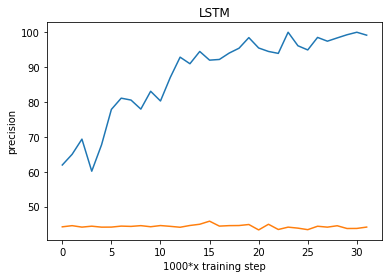

precision of the model on thevalidationdata: 44.3537712097168%
tensor([0.8990, 0.9924, 0.9845, 0.9876, 0.9786, 0.9970, 0.9999, 0.7814, 0.9264,
        0.8523, 0.9274, 0.9998, 0.8090, 0.9866, 0.9868, 0.9958, 0.9670, 0.8731,
        0.6514, 0.9563, 0.9995, 0.9976, 0.9833, 0.6490, 0.8859, 0.8121, 0.8372,
        0.9339, 0.9858, 0.5595, 0.9992, 0.9319, 0.6010, 0.9511, 0.6922, 0.8417,
        0.5250, 0.9400, 0.9726, 0.7053, 0.6592, 0.9208, 0.9897, 0.6224, 0.8922,
        0.9691, 0.8931, 1.0000, 1.0000, 0.9983, 0.9869, 0.9954, 0.8621, 0.9101,
        0.9762, 0.9816, 0.9741, 0.9969, 0.9957, 0.7549, 0.9917, 0.9999, 0.9993,
        0.9417, 0.9791, 0.9983, 0.9786, 0.9969, 0.9933, 0.5582, 0.8442, 0.6334,
        0.9869, 0.9389, 0.9306, 0.9904, 0.9738, 0.9814, 0.9862, 0.9980, 0.5527,
        0.5990, 0.9714, 0.6848, 0.9329, 0.9999, 0.7646, 0.9905, 0.8533, 0.9994,
        0.9962, 0.9884, 1.0000, 0.7747, 0.8540, 0.9998, 1.0000, 0.9142, 0.8852,
        0.8742], device='cuda:1')
current i is 81
Filter 

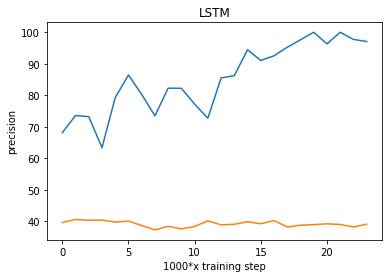

precision of the model on thevalidationdata: 39.0875129699707%
tensor([0.9858, 0.9996, 0.9919, 0.9986, 0.6493, 0.9941, 0.9793, 0.9976, 0.9991,
        0.9966, 0.9988, 1.0000, 0.7184, 0.9870, 0.9723, 0.9958, 0.6358, 0.8089,
        0.8325, 0.8942, 0.9988, 0.9955, 0.9999, 0.9999, 0.9951, 0.9949, 0.9902,
        0.9819, 0.9986, 0.6313, 0.9850, 0.9997, 0.8917, 0.6868, 0.8597, 0.6838,
        0.9982, 0.9915, 0.9978, 0.9899, 0.9886, 0.9814, 0.9189, 0.9977, 0.9983,
        0.8475, 0.5948, 0.9901, 0.9991, 0.9352, 1.0000, 0.9979, 0.9416, 0.9856,
        0.9882, 0.7739, 0.9174, 0.9984, 0.9973, 0.9999, 0.9802, 0.9991, 0.5126,
        0.9993, 0.9992, 1.0000, 1.0000, 1.0000, 1.0000, 0.9560, 0.7702, 0.9988,
        0.8319, 0.9999, 0.9971, 0.9999, 0.9996, 0.9933, 0.9941, 0.9529, 0.9967,
        0.9984, 0.6954, 0.9058, 0.9875, 0.8172, 0.5596, 0.9934, 0.9999, 0.9946,
        0.7031, 0.9993, 0.9997, 0.9962, 0.9941, 0.9571, 0.9960, 0.9830, 0.9996,
        0.9880], device='cuda:1')
current i is 83
Filter 

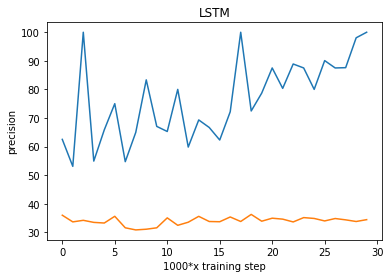

precision of the model on thevalidationdata: 34.40678024291992%
tensor([0.9476, 0.9576, 0.5277, 0.6910, 0.8691, 0.7135, 0.9352, 0.9173, 0.8762,
        0.9972, 0.7293, 0.7646, 0.9903, 0.8067, 0.9371, 0.9952, 0.8364, 0.9997,
        0.9944, 0.9774, 0.9990, 0.8421, 0.9980, 0.9311, 0.7406, 0.7340, 0.5973,
        0.9914, 0.8658, 0.9975, 0.6611, 0.8112, 0.9372, 0.9654, 0.9721, 0.6109,
        0.8433, 0.9523, 0.9863, 0.9813, 0.9273, 0.9874, 0.9996, 0.9998, 0.9828,
        0.9944, 0.9980, 0.9224, 0.7947, 0.9735, 0.9940, 0.9128, 0.9994, 0.9875,
        0.8285, 0.9129, 0.9992, 0.9985, 0.9990, 0.9824, 0.9616, 0.9001, 0.9997,
        0.9918, 0.9575, 0.9937, 0.9144, 0.8585, 0.9703, 0.9361, 0.9855, 0.9932,
        0.9909, 0.9480, 0.9955, 0.9987, 0.9830, 0.7066, 0.9932, 0.7571, 0.5444,
        0.7358, 0.7981, 0.8727, 0.8673, 0.9619, 0.9135, 0.6569, 0.8217, 0.6401,
        0.9995, 0.6791, 0.9997, 0.5724, 0.9942, 0.8082, 0.5107, 0.9957, 0.9639,
        0.9202], device='cuda:1')
current i is 84
Filter

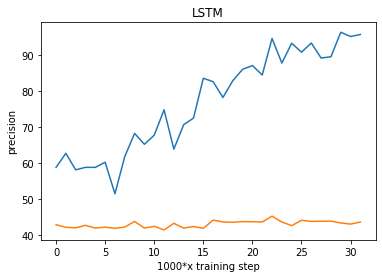

precision of the model on thevalidationdata: 42.3761100769043%
tensor([0.7922, 0.9731, 0.9948, 0.9999, 0.9936, 0.9507, 0.9663, 0.8285, 0.9722,
        0.5521, 0.5763, 0.9799, 0.9699, 0.6618, 0.9259, 0.9256, 0.5534, 0.9709,
        0.9304, 0.9829, 0.9950, 0.9673, 0.5048, 0.9997, 0.8595, 0.7057, 0.9765,
        0.9896, 0.6365, 0.9609, 0.9997, 0.9852, 0.9948, 0.7992, 0.9997, 0.9987,
        0.7416, 0.7910, 0.7395, 0.9997, 0.9037, 0.8926, 0.9799, 0.8327, 0.7427,
        0.9990, 0.6540, 0.9992, 0.9936, 0.6984, 0.9999, 0.9933, 0.9009, 0.9989,
        0.8584, 0.9995, 0.9387, 0.8227, 0.8089, 0.8756, 0.7986, 0.9953, 0.7979,
        0.6672, 0.7552, 0.9351, 0.9000, 0.7217, 0.9855, 0.9956, 0.9352, 0.9969,
        0.9995, 0.9987, 0.9675, 0.8566, 0.6082, 0.8397, 0.8645, 0.7362, 0.9972,
        0.9134, 0.5417, 0.9503, 0.5787, 0.9975, 0.9569, 0.9686, 0.9576, 0.9982,
        0.8287, 0.9963, 0.6987, 0.9316, 0.6790, 0.8981, 0.9919, 0.9930, 0.9198,
        0.9646], device='cuda:1')
current i is 85
Filter 

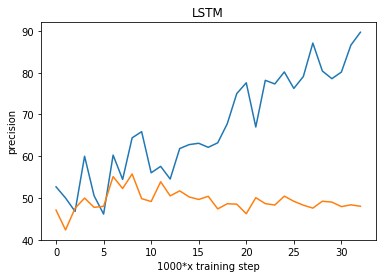

precision of the model on thevalidationdata: 48.0286750793457%
tensor([0.9823, 0.9886, 0.8968, 0.9988, 0.9557, 0.9976, 0.9732, 0.6838, 0.6824,
        0.8765, 0.6195, 0.8495, 0.5597, 0.6758, 0.9778, 0.8811, 0.7639, 0.9328,
        0.8736, 0.9934, 0.7112, 0.8452, 0.9947, 0.6944, 0.6946, 0.5139, 0.8515,
        0.7165, 0.9560, 0.9741, 0.9991, 0.9626, 0.9969, 0.5970, 0.7329, 0.9872,
        0.9903, 0.8867, 0.9763, 0.8920, 0.9221, 0.8707, 0.9758, 0.5958, 0.9628,
        0.7037, 0.8126, 0.5755, 0.9918, 0.8631, 0.9732, 0.5002, 0.6949, 0.6117,
        0.8066, 0.5267, 0.5917, 0.7266, 0.9985, 0.9170, 0.5473, 0.9974, 0.9541,
        0.9894, 0.9575, 0.9794, 0.9428, 0.9956, 0.8180, 0.6684, 0.8285, 0.6432,
        0.9879, 0.9924, 0.5601, 0.7942, 0.9748, 0.6257, 0.7473, 0.9994, 0.9379,
        0.8359, 0.5477, 0.6678, 0.9980, 0.6299, 0.8559, 0.6328, 0.6482, 0.8291,
        0.8390, 0.8792, 0.5076, 0.8844, 0.9989, 0.9077, 0.8331, 0.9965, 0.9707,
        0.8298], device='cuda:1')
current i is 86
Filter 

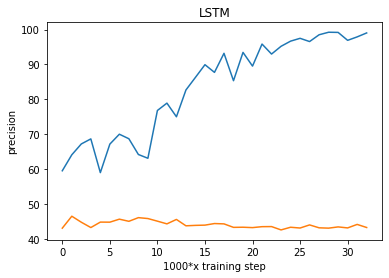

precision of the model on thevalidationdata: 43.26788330078125%
tensor([0.9965, 0.9985, 0.9657, 0.6174, 0.9517, 0.8703, 0.6952, 0.8546, 0.9967,
        0.6249, 0.9992, 0.9985, 0.9984, 0.8336, 0.9996, 0.8840, 0.8598, 0.6458,
        0.9997, 0.8800, 0.9848, 0.9973, 0.9992, 0.6485, 0.9108, 0.9941, 0.9473,
        0.9939, 0.9984, 0.9997, 0.6922, 0.9954, 0.9991, 0.9527, 0.8041, 0.9962,
        0.5473, 0.7086, 0.9439, 0.8397, 0.9716, 0.9553, 0.9986, 0.9963, 0.9994,
        0.9999, 0.5370, 0.9990, 0.9936, 0.5210, 0.9872, 0.6664, 0.8994, 0.9972,
        0.9995, 0.9993, 0.6087, 0.7790, 0.8912, 0.7583, 0.9988, 0.9156, 0.9969,
        0.9799, 0.9987, 0.9025, 0.9196, 0.6726, 0.6439, 0.9648, 0.9983, 0.9974,
        0.9999, 0.5236, 0.5369, 0.9234, 0.9716, 0.9994, 0.9825, 0.9233, 0.5615,
        0.9576, 0.9974, 0.9952, 0.8332, 0.6711, 0.9848, 0.9760, 0.9865, 0.9964,
        0.9390, 0.9117, 0.9976, 0.9838, 0.9944, 0.9355, 0.5544, 1.0000, 0.8966,
        0.6504], device='cuda:1')
current i is 87
Filter

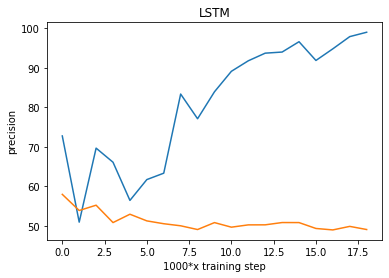

precision of the model on thevalidationdata: 49.85795593261719%
tensor([0.9999, 0.9786, 0.9320, 0.7336, 0.9777, 0.9717, 0.8213, 1.0000, 0.9720,
        0.6654, 0.6014, 0.9658, 0.9998, 0.9997, 0.9933, 0.9982, 0.9056, 0.9987,
        0.9908, 0.9985, 1.0000, 0.9984, 0.9952, 0.7824, 0.8134, 0.9894, 0.9963,
        0.9633, 0.9993, 0.9999, 0.8440, 0.9996, 1.0000, 0.9977, 0.9678, 0.6179,
        0.7286, 0.9839, 0.6722, 0.9110, 0.9913, 0.9990, 0.6970, 0.9702, 0.8899,
        1.0000, 0.9987, 0.9939, 0.9964, 0.9383, 0.8394, 0.9995, 0.7392, 0.8086,
        0.9710, 0.9992, 0.9992, 0.9947, 0.9405, 0.9643, 0.8842, 0.9953, 0.9979,
        0.9992, 0.9736, 0.9781, 0.6311, 0.9385, 0.5910, 0.9999, 0.9940, 0.9978,
        0.9737, 0.9143, 0.9329, 0.9988, 0.9756, 0.5039, 0.9990, 0.5809, 0.9999,
        0.9865, 0.9914, 0.8065, 0.9402, 0.9950, 0.9913, 0.9899, 0.5530, 0.9132,
        0.9817, 0.9484, 0.9967, 0.9984, 0.9979, 0.9898, 0.9999, 0.9885, 0.9992,
        0.8708], device='cuda:1')
current i is 88
Filter

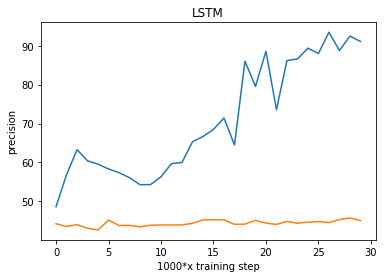

precision of the model on thevalidationdata: 44.93214416503906%
tensor([0.9807, 0.9940, 0.9985, 0.9999, 0.9998, 0.7488, 0.7132, 0.9229, 0.8005,
        0.9947, 0.7840, 0.9846, 0.9795, 0.7034, 0.9377, 0.6507, 0.9988, 0.8853,
        0.9416, 0.8831, 0.7994, 0.6480, 0.8093, 0.9903, 0.7884, 0.6271, 0.6848,
        0.7448, 0.9948, 0.9935, 0.6659, 0.9436, 0.6293, 0.9849, 0.5502, 0.9987,
        0.9986, 0.9618, 0.9267, 0.8202, 0.6990, 0.9392, 0.9978, 0.9906, 0.8185,
        0.9870, 0.9899, 0.9998, 0.6235, 0.8495, 0.6769, 0.8403, 0.9319, 0.8342,
        0.9996, 0.9818, 0.9687, 0.9943, 0.9838, 0.5842, 0.5471, 0.9755, 0.9992,
        0.5151, 0.9710, 0.9948, 0.8766, 0.7953, 0.9029, 0.9794, 0.6864, 0.9982,
        0.9999, 0.6926, 0.9976, 0.9707, 0.9906, 0.9981, 0.8139, 0.6997, 0.9615,
        0.9888, 0.9325, 0.9677, 0.9131, 0.9984, 0.9999, 0.9964, 0.9350, 0.8006,
        0.7475, 0.9971, 0.5837, 0.6160, 0.9991, 0.6063, 0.9915, 0.9996, 0.9957,
        0.9966], device='cuda:1')
current i is 89
Filter

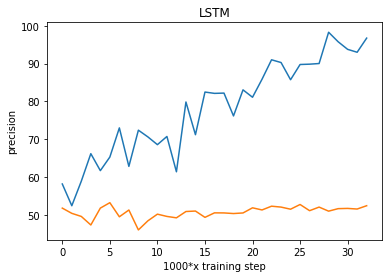

precision of the model on thevalidationdata: 51.76797866821289%
tensor([0.9946, 0.9844, 0.9954, 0.7869, 0.9299, 0.9455, 0.9961, 0.9911, 0.9992,
        0.9986, 0.8652, 0.9548, 0.8989, 0.7285, 0.9209, 0.9961, 0.9995, 0.9954,
        0.5683, 0.5562, 0.5045, 0.9970, 0.5708, 0.7378, 0.9373, 0.6864, 0.9994,
        0.9816, 0.8312, 0.7228, 0.9464, 0.7933, 0.9462, 0.9140, 0.9995, 0.9973,
        0.9482, 0.6693, 0.7040, 0.9746, 0.5632, 0.9798, 0.9999, 0.9599, 0.5320,
        0.9949, 0.9988, 0.9524, 0.8826, 0.7303, 0.9223, 0.5731, 0.9086, 0.9854,
        0.9992, 0.9991, 0.9990, 0.9865, 0.9955, 0.5866, 0.5827, 0.9988, 0.9972,
        0.8447, 0.9171, 0.9987, 0.7479, 0.9820, 0.9977, 0.9133, 0.9997, 0.8183,
        0.9932, 0.9962, 0.9844, 0.6247, 0.7276, 0.8038, 0.9996, 0.8264, 0.9961,
        0.9998, 0.6639, 0.6930, 0.9536, 0.9954, 0.8173, 0.9170, 0.8899, 0.9952,
        0.9486, 0.7649, 0.7625, 0.8648, 0.7775, 0.9951, 0.9989, 0.9985, 0.8597,
        0.9990], device='cuda:1')


In [12]:
result = ResNet1D_LSTM_rolling_window(df_train_dict, df_valid_dict)

In [13]:
def transform_dict_to_df(result):
    result_df_dict={}
    for i in result.keys():
        valid_index_list, score, predicted, train_label_list = result[str(i)]
        first = np.array(valid_index_list)[:,0].reshape(-1,)
        second = np.array(valid_index_list)[:,1].reshape(-1,)
        third = score.cpu().reshape(-1,1).reshape(-1,)
        fourth = train_label_list.reshape(-1,)
        fifth = predicted.reshape(-1,) 
        third = np.array(third)
        fifth = np.array(fifth.cpu())
        data = np.array([first,second,third,fourth,fifth])
        data = np.transpose(data, (1,0))
        result_df_dict[str(i)] = pd.DataFrame(data=data, columns=['date','index','score','label','prediction'])
    return result_df_dict

In [21]:
result_df_dict = transform_dict_to_df(result)

In [15]:
def pre_processing(result_df_dict):
    processed = {}
    for i in result_df_dict.keys():
        print(i)
        df = result_df_dict[str(i)]
        df['prediction'] = df['prediction'].astype('float64')
        df['label'] = df['label'].astype('float64')
        df['score'] = df['score'].astype('float64')
        idx = df[df['prediction']==0].index
        df.loc[idx,'score'] = 1-df.loc[idx,'score']
        print(df)
        processed[str(i)] = df
    return processed

In [16]:
processed = pre_processing(result_df_dict)

1
            date      index     score  label  prediction
0     2013-03-14  000001.SZ  0.998111    1.0         1.0
1     2013-03-15  000001.SZ  0.190393    0.0         0.0
2     2013-03-18  000001.SZ  0.000001    0.0         0.0
3     2013-03-14  000002.SZ  0.993373    0.0         1.0
4     2013-03-15  000002.SZ  0.001547    1.0         0.0
...          ...        ...       ...    ...         ...
6993  2013-03-15  603399.SH  0.056804    0.0         0.0
6994  2013-03-18  603399.SH  0.013560    1.0         0.0
6995  2013-03-14  603766.SH  0.996016    1.0         1.0
6996  2013-03-15  603766.SH  0.000241    0.0         0.0
6997  2013-03-18  603766.SH  0.000060    1.0         0.0

[6998 rows x 5 columns]
2
            date      index     score  label  prediction
0     2013-04-15  000001.SZ  0.962062    0.0         1.0
1     2013-04-15  000002.SZ  0.991262    1.0         1.0
2     2013-04-15  000004.SZ  0.716562    0.0         1.0
3     2013-04-15  000005.SZ  0.931711    1.0         1.0
4 

            date      index     score  label  prediction
0     2014-12-18  000001.SZ  0.011390    0.0         0.0
1     2014-12-19  000001.SZ  0.999727    1.0         1.0
2     2014-12-22  000001.SZ  0.000083    0.0         0.0
3     2014-12-18  000002.SZ  0.000333    0.0         0.0
4     2014-12-19  000002.SZ  0.614354    1.0         1.0
...          ...        ...       ...    ...         ...
6397  2014-12-19  603699.SH  0.039998    0.0         0.0
6398  2014-12-22  603699.SH  0.995185    1.0         1.0
6399  2014-12-18  603993.SH  0.999992    1.0         1.0
6400  2014-12-19  603993.SH  0.263472    1.0         0.0
6401  2014-12-22  603993.SH  0.999927    0.0         1.0

[6402 rows x 5 columns]
25
            date      index     score  label  prediction
0     2015-01-15  000001.SZ  0.025284    0.0         0.0
1     2015-01-16  000001.SZ  0.001009    1.0         0.0
2     2015-01-19  000001.SZ  0.004578    0.0         0.0
3     2015-01-15  000002.SZ  0.000899    0.0         0.0
4  

            date      index     score  label  prediction
0     2016-09-26  000001.SZ  0.030409    0.0         0.0
1     2016-09-26  000002.SZ  0.000511    0.0         0.0
2     2016-09-26  000005.SZ  0.147269    1.0         0.0
3     2016-09-26  000006.SZ  0.065903    0.0         0.0
4     2016-09-26  000007.SZ  0.074113    0.0         0.0
...          ...        ...       ...    ...         ...
2496  2016-09-26  603993.SH  0.625678    0.0         1.0
2497  2016-09-26  603996.SH  0.006137    0.0         0.0
2498  2016-09-26  603997.SH  0.000776    1.0         0.0
2499  2016-09-26  603998.SH  0.000164    0.0         0.0
2500  2016-09-26  603999.SH  0.200811    1.0         0.0

[2501 rows x 5 columns]
48
            date      index     score  label  prediction
0     2016-10-20  000001.SZ  0.034623    1.0         0.0
1     2016-10-21  000001.SZ  0.544593    1.0         1.0
2     2016-10-24  000001.SZ  0.599029    0.0         1.0
3     2016-10-20  000002.SZ  0.992032    0.0         1.0
4  

            date      index     score  label  prediction
0     2018-05-31  000001.SZ  0.002063    1.0         0.0
1     2018-06-01  000001.SZ  0.025860    0.0         0.0
2     2018-06-04  000001.SZ  0.001046    0.0         0.0
3     2018-05-31  000002.SZ  0.003043    1.0         0.0
4     2018-06-01  000002.SZ  0.608785    1.0         1.0
...          ...        ...       ...    ...         ...
9342  2018-06-01  603998.SH  0.000378    0.0         0.0
9343  2018-06-04  603998.SH  0.029632    1.0         0.0
9344  2018-05-31  603999.SH  0.000309    0.0         0.0
9345  2018-06-01  603999.SH  0.003843    0.0         0.0
9346  2018-06-04  603999.SH  0.630514    0.0         1.0

[9347 rows x 5 columns]
70
            date      index     score  label  prediction
0     2018-06-29  000001.SZ  0.992849    0.0         1.0
1     2018-07-02  000001.SZ  0.998292    1.0         1.0
2     2018-06-29  000002.SZ  0.998280    0.0         1.0
3     2018-07-02  000002.SZ  0.397578    1.0         0.0
4  

In [17]:
def sort_top_k(result_df_dict,k):
    top_k_df={}
    for i in result_df_dict.keys():
        #print(i)
        temp = result_df_dict[str(i)].sort_values('score', axis=0, ascending=False).groupby(by = 'date').head(k)
        #print(temp)
        top_k_df[str(i)] = temp
    return top_k_df

In [18]:
def precision_top_k(head):
    pre=[]
    for i in head.keys():
        pre.append(sum(head[str(i)]['label']*head[str(i)]['prediction'])/sum(head[str(i)]['prediction']))
    return pre

In [19]:
def mult_k(processed,k):
    pre_dict={}
    for i in k:
        print(i)
        head = sort_top_k(processed,i)
        pre_dict[str(i)]=precision_top_k(head)
    for i in k:
        plt.plot(pre_dict[str(i)],label='top'+str(i))
        plt.legend()
    plt.ylabel('precision')
    plt.show()
    return pre_dict

10
20
40
80
160
320
640
1280
100000


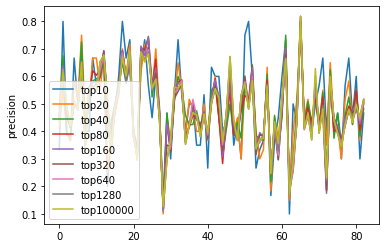

In [20]:
precision_diction = mult_k(processed,[10,20,40,80,160,320,640,1280,100000])

In [22]:
for i in precision_diction.keys():
    print('top'+str(i),'mean precision:',sum(precision_diction[str(i)])/len(precision_diction[str(i)]))

top10 mean precision: 0.49618473895582343
top20 mean precision: 0.48473895582329274
top40 mean precision: 0.48077309236947774
top80 mean precision: 0.4813554216867467
top160 mean precision: 0.48072707496653305
top320 mean precision: 0.4767636968538361
top640 mean precision: 0.4765276329239919
top1280 mean precision: 0.47789069417350655
top100000 mean precision: 0.4784168089371444
